# Project 4 

## Problem Statement

## Executive Summary

### Import libraries

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

import pyreadr
import myfunctions as f
import io

%matplotlib inline

### Data Import

In [84]:
df_train = pd.read_csv('../datasets/train.csv')
df_test = pd.read_csv('../datasets/test.csv')
df_spray = pd.read_csv('../datasets/spray.csv')
df_weather = pd.read_csv('../datasets/weather.csv')

## Data Cleaning

### General Cleaning for all dataframes

In [85]:
df_train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [86]:
df_weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [87]:
df_spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [88]:
# Apply lower() to column names for all 3 dataframes
df_weather.columns = df_weather.columns.str.lower()
df_train.columns = df_train.columns.str.lower()
df_spray.columns = df_spray.columns.str.lower()
df_test.columns = df_test.columns.str.lower()

In [89]:
# Check datatypes
print('Train dataset')
print(df_train.dtypes)
print()
print('Weather dataset')
print(df_weather.dtypes)
print()
print('Spray dataset')
print(df_spray.dtypes)
print()

Train dataset
date                       object
address                    object
species                    object
block                       int64
street                     object
trap                       object
addressnumberandstreet     object
latitude                  float64
longitude                 float64
addressaccuracy             int64
nummosquitos                int64
wnvpresent                  int64
dtype: object

Weather dataset
station          int64
date            object
tmax             int64
tmin             int64
tavg            object
depart          object
dewpoint         int64
wetbulb         object
heat            object
cool            object
sunrise         object
sunset          object
codesum         object
depth           object
water1          object
snowfall        object
preciptotal     object
stnpressure     object
sealevel        object
resultspeed    float64
resultdir        int64
avgspeed        object
dtype: object

Spray dataset
date        

In [90]:
# Change Date datatype to datetime
df_train['date'] = pd.to_datetime(df_train['date'])
df_weather['date'] = pd.to_datetime(df_weather['date'])
df_spray['date'] = pd.to_datetime(df_spray['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

In [91]:
# Check datatypes
print('Train dataset')
print(df_train.dtypes)
print()
print('Weather dataset')
print(df_weather.dtypes)
print()
print('Spray dataset')
print(df_spray.dtypes)
print()

Train dataset
date                      datetime64[ns]
address                           object
species                           object
block                              int64
street                            object
trap                              object
addressnumberandstreet            object
latitude                         float64
longitude                        float64
addressaccuracy                    int64
nummosquitos                       int64
wnvpresent                         int64
dtype: object

Weather dataset
station                 int64
date           datetime64[ns]
tmax                    int64
tmin                    int64
tavg                   object
depart                 object
dewpoint                int64
wetbulb                object
heat                   object
cool                   object
sunrise                object
sunset                 object
codesum                object
depth                  object
water1                 object
snowfall     

In [92]:
# Create `day`, `month` and `year` columns for all 3 dataframes
df_spray['day'] = df_spray['date'].map(lambda x: x.day)
df_spray['month'] = df_spray['date'].map(lambda x: x.month)
df_spray['year'] = df_spray['date'].map(lambda x: x.year)

df_weather['day'] = df_weather['date'].map(lambda x: x.day)
df_weather['month'] = df_weather['date'].map(lambda x: x.month)
df_weather['year'] = df_weather['date'].map(lambda x: x.year)

df_train['day'] = df_train['date'].map(lambda x: x.day)
df_train['month'] = df_train['date'].map(lambda x: x.month)
df_train['year'] = df_train['date'].map(lambda x: x.year)

df_test['day'] = df_test['date'].map(lambda x: x.day)
df_test['month'] = df_test['date'].map(lambda x: x.month)
df_test['year'] = df_test['date'].map(lambda x: x.year)

In [93]:
# View data shapes
print(f'Train dataset: {df_train.shape}')
print(f'Weather dataset: {df_weather.shape}')
print(f'Spray dataset: {df_spray.shape}')

Train dataset: (10506, 15)
Weather dataset: (2944, 25)
Spray dataset: (14835, 7)


In [94]:
# Check for NA values
print(f'Train dataset: {df_train.isnull().sum().sum()}')
print(f'Weather dataset: {df_weather.isnull().sum().sum()}')
print(f'Spray dataset: {df_spray.isnull().sum().sum()}')
print(f'Test dataset: {df_test.isnull().sum().sum()}')

Train dataset: 0
Weather dataset: 0
Spray dataset: 584
Test dataset: 0


### Data cleaning for df_spray

In [95]:
# Closer look at Spray dataset
print(df_spray.isnull().sum())

date           0
time         584
latitude       0
longitude      0
day            0
month          0
year           0
dtype: int64


**Comment**

Column 'Time' has 584 empty cells but it is not important for our analysis.
The null values does not appear at random. Therefore, we will drop the column

In [96]:
df_spray.drop(columns='time',inplace=True)

In [97]:
df_spray.head()

,date,latitude,longitude,day,month,year
0,2011-08-29,42.391623,-88.089163,29,8,2011
1,2011-08-29,42.391348,-88.089163,29,8,2011
2,2011-08-29,42.391022,-88.089157,29,8,2011
3,2011-08-29,42.390637,-88.089158,29,8,2011
4,2011-08-29,42.390410,-88.088858,29,8,2011


### Data cleaning for df_weather

In [98]:
# Define function to replace entires with M, blank spaces and '-' with Nan values, while T was replace with 0.05
# https://wgntv.com/weather/what-are-traces-of-precipitation/
def update_cols(df):
    df.replace(['M','-',' ', '  T'],
               [np.nan, np.nan, np.nan, 0.05],
               inplace = True)
    
update_cols(df_weather)

In [99]:
df_weather.head()
# Depart
# Departure from normal. The difference between column 4 and the 30 year normal temperature 
# for this date. A minus (-) is number of degrees below normal.
# A zero (0) indicates that the average for that day was the Normal.

# DewPoint
# The dew point is the temperature the air needs to be cooled to (at constant pressure) 
# in order to achieve a relative humidity (RH) of 100%.

# WetBulb
# At 100% relative humidity, the wet-bulb temperature is equal to the air temperature 
# (dry-bulb temperature) and it is lower at lower humidity.

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,day,month,year
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,0.0,0.00,29.10,29.82,1.7,27,9.2,1,5,2007
1,2,2007-05-01,84,52,68,NaN,51,57,0,3,...,NaN,0.00,29.18,29.82,2.7,25,9.6,1,5,2007
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,0.0,0.00,29.38,30.09,13.0,4,13.4,2,5,2007
3,2,2007-05-02,60,43,52,NaN,42,47,13,0,...,NaN,0.00,29.44,30.08,13.3,2,13.4,2,5,2007
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,0.0,0.00,29.39,30.12,11.7,7,11.9,3,5,2007


In [100]:
# Check for null
df_weather.isnull().sum().sort_values(ascending=False)

water1         2944
codesum        1609
depart         1472
sunrise        1472
sunset         1472
depth          1472
snowfall       1472
tavg             11
cool             11
heat             11
sealevel          9
stnpressure       4
wetbulb           4
avgspeed          3
preciptotal       2
tmin              0
tmax              0
date              0
year              0
dewpoint          0
month             0
resultspeed       0
resultdir         0
day               0
station           0
dtype: int64

In [101]:
# Drop water1 column as it is missing all the data
df_weather.drop(['water1'], axis = 1, inplace= True)

# Replace Nan values in codesum column with 'MODERATE'
df_weather['codesum'] = df_weather['codesum'].replace(np.nan, 'MODERATE')

In [102]:
df_weather.dtypes

station                 int64
date           datetime64[ns]
tmax                    int64
tmin                    int64
tavg                   object
depart                 object
dewpoint                int64
wetbulb                object
heat                   object
cool                   object
sunrise                object
sunset                 object
codesum                object
depth                  object
snowfall               object
preciptotal            object
stnpressure            object
sealevel               object
resultspeed           float64
resultdir               int64
avgspeed               object
day                     int64
month                   int64
year                    int64
dtype: object

In [103]:
col_toflt = ['preciptotal', 'stnpressure', 'sealevel',
             'avgspeed', 'preciptotal', 'tavg',
             'depart', 'wetbulb', 'heat', 'cool',
             'sunrise', 'sunset']

for col in col_toflt:
    df_weather[col] = df_weather[col].astype(float)

In [104]:
df_weather.dtypes

station                 int64
date           datetime64[ns]
tmax                    int64
tmin                    int64
tavg                  float64
depart                float64
dewpoint                int64
wetbulb               float64
heat                  float64
cool                  float64
sunrise               float64
sunset                float64
codesum                object
depth                  object
snowfall               object
preciptotal           float64
stnpressure           float64
sealevel              float64
resultspeed           float64
resultdir               int64
avgspeed              float64
day                     int64
month                   int64
year                    int64
dtype: object

In [107]:
# Define function to convert temperature to Celsius
def fahrenheit_to_celsius(df,column_names):
    '''
    Convert temperature from Fahrenheit to Celsius
    
    Takes:
    df - DataFrame
    column_names - (list of str) - names of columns for conversion
    
    Returns:
    df
    '''
    for name in column_names:
        try:
            df[name] = round((df[name]-32)*5/9,2)
        except TypeError:
            continue
    return df

df_weather = fahrenheit_to_celsius(df_weather,
                      ['tmax','tmin','tavg','depart','dewpoint','wetbulb'])

## Exploratory Data Analysis and Feature Engineering

### EDA - Weather dataset

In [108]:
# Masking weather data by station
df_weather_st1 = df_weather[df_weather['station']==1]
df_weather_st2 = df_weather[df_weather['station']==2]
# Resetting indices
df_weather_st1.reset_index(inplace=True,drop=True)
df_weather_st2.reset_index(inplace=True,drop=True)

In [109]:
# Checking for missing values from station 1
df_weather_st1.isnull().sum()

station        0
date           0
tmax           0
tmin           0
tavg           0
depart         0
dewpoint       0
wetbulb        3
heat           0
cool           0
sunrise        0
sunset         0
codesum        0
depth          0
snowfall       0
preciptotal    0
stnpressure    2
sealevel       5
resultspeed    0
resultdir      0
avgspeed       0
day            0
month          0
year           0
dtype: int64

In [110]:
# Checking for missing values from station 2
df_weather_st2.isnull().sum()
# There are much more missing values in station 2

station           0
date              0
tmax              0
tmin              0
tavg             11
depart         1472
dewpoint          0
wetbulb           1
heat             11
cool             11
sunrise        1472
sunset         1472
codesum           0
depth          1472
snowfall       1472
preciptotal       2
stnpressure       2
sealevel          4
resultspeed       0
resultdir         0
avgspeed          3
day               0
month             0
year              0
dtype: int64

In [111]:
# Merging two station in one df
weather_two_stations = pd.merge(df_weather_st1,df_weather_st2,on='date')

In [112]:
# Creation a function for scatter- and box-plots
def scatter(column_list,df=weather_two_stations):
    '''
    Takes:
    column_list (list of str) - list of column names
    df - dataframe
    Plot scatterplot station 1 against station 2
    '''
    nrows = int(np.ceil(len(column_list)/2))
    fig,ax=plt.subplots(nrows=nrows,ncols=2,figsize=(20,50))
    for i,name in enumerate(column_list):
        x = df[name + '_x']
        y = df[name +'_y']
        if i <=nrows-1:
            c=0
            a = i
        else:
            c=1
            a = i - nrows

        try:
            ax[a,c].scatter(x,y)
            ax[a,c].set_title(name,fontsize=15)
            ax[a,c].set_xlabel('Station 1')
            ax[a,c].set_xlabel('Station 2')
            plt.tight_layout(pad=0.4, w_pad=2, h_pad=2)
        except:
            pass

In [113]:
# Choosing columns for scatterplots
column_names = [name.split('_')[0] for name in ['station_x', 'tmax_x', 'tmin_x', 
                                                'tavg_x', 'depart_x',
       'dewpoint_x', 'wetbulb_x', 'heat_x', 'cool_x', 'sunrise_x', 'sunset_x',
       'codesum_x', 'depth_x', 'snowfall_x', 'preciptotal_x', 'stnpressure_x',
       'sealevel_x', 'resultspeed_x', 'resultdir_x', 'avgspeed_x', 'day_x',
       'month_x', 'year_x', 'station_y', 'tmax_y', 'tmin_y', 'tavg_y',
       'depart_y', 'dewpoint_y', 'wetbulb_y', 'heat_y', 'cool_y', 'sunrise_y',
       'sunset_y', 'codesum_y', 'depth_y', 'snowfall_y', 'preciptotal_y',
       'stnpressure_y', 'sealevel_y', 'resultspeed_y', 'resultdir_y',
       'avgspeed_y', 'day_y', 'month_y', 'year_y']]
# Leave only unique names of columns
column_names = list(set(column_names))

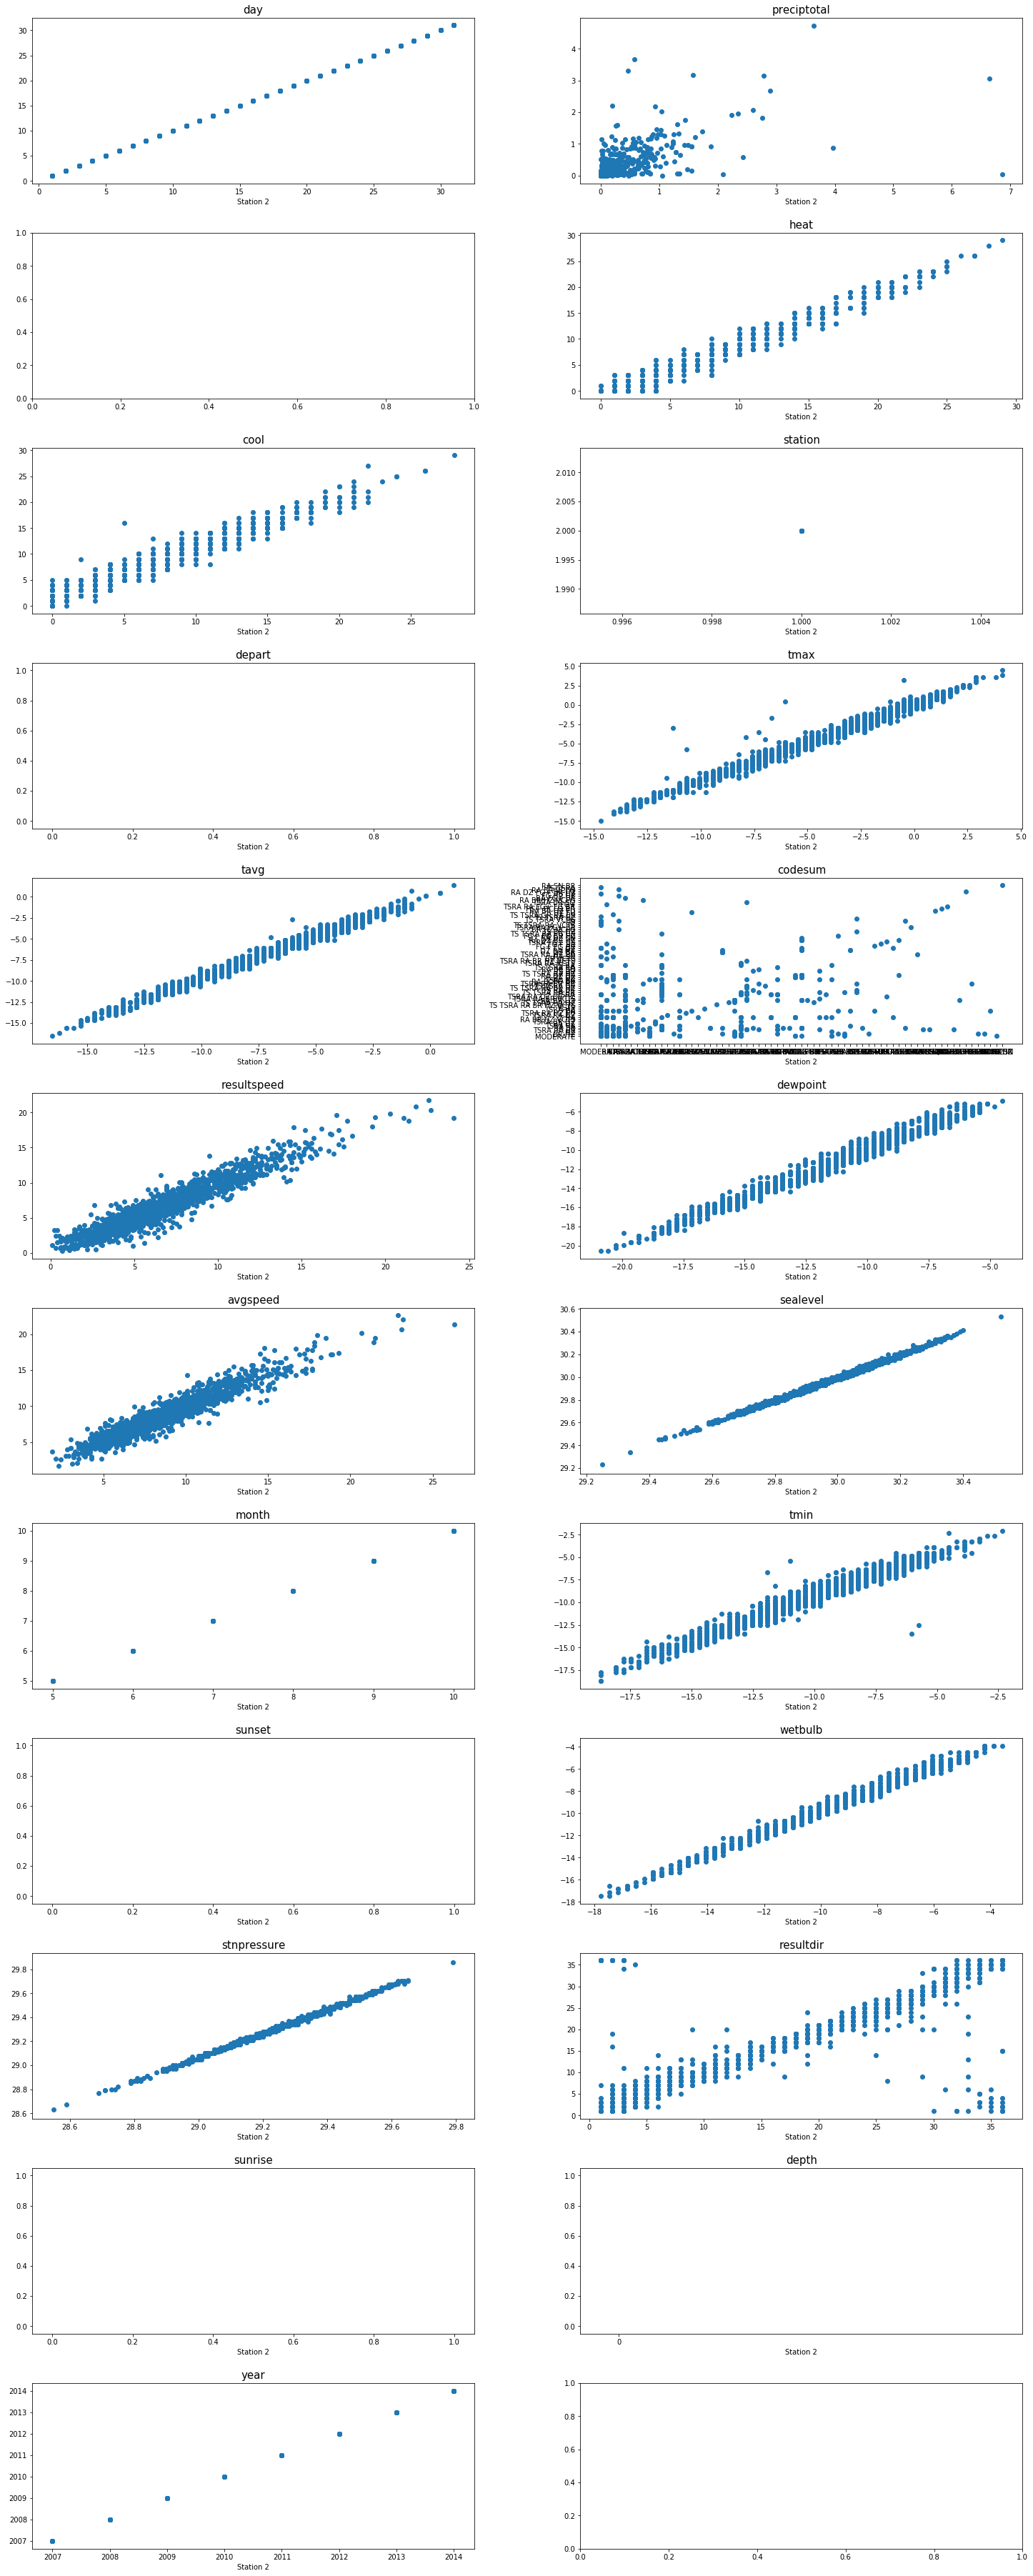

In [114]:
scatter(column_names)

**Comment**


As graphs above have shown, weather data from station 1 and station 2 is very similar.
But station 1 has much less missing values. The decision is to fill NA in station 1 with info from station 2 and drop station 2 columns.

In [115]:
index_st1=df_weather_st1[df_weather_st1.isnull().any(axis=1)].index
df_weather_st1[df_weather_st1.isnull().any(axis=1)]

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,day,month,year
416,1,2009-06-18,-2.96,-8.83,-5.74,-27.34,-8.21,-6.98,0.0,6.0,...,0.0,0.12,29.08,NaN,6.7,16,7.9,18,6,2009
424,1,2009-06-26,-1.11,-6.36,-3.58,-25.49,-9.13,NaN,0.0,13.0,...,0.0,0.00,NaN,29.85,6.4,4,8.2,26,6,2009
497,1,2009-09-07,-3.89,-9.44,-6.67,-27.34,-9.44,-8.52,0.0,3.0,...,0.0,0.00,29.39,NaN,5.8,3,4.0,7,9,2009
866,1,2011-09-08,-4.51,-10.06,-7.28,-27.66,-11.29,-9.44,0.0,1.0,...,0.0,0.05,29.34,NaN,13.0,2,13.4,8,9,2011
878,1,2011-09-20,-4.82,-12.53,-8.52,-27.66,-10.99,-9.76,3.0,0.0,...,0.0,0.00,29.26,NaN,7.3,18,7.3,20,9,2011
1045,1,2012-09-03,-0.49,-5.74,-2.96,-23.95,-6.05,-5.12,0.0,15.0,...,0.0,0.00,29.17,NaN,4.6,6,4.4,3,9,2012
1205,1,2013-08-10,-2.66,-7.90,-5.12,-27.66,-10.06,NaN,0.0,8.0,...,0.0,0.00,NaN,30.08,5.3,5,6.5,10,8,2013
1206,1,2013-08-11,-2.66,-9.13,-5.74,-28.27,-8.83,NaN,0.0,6.0,...,0.0,0.01,29.35,30.07,2.0,27,3.0,11,8,2013


In [116]:
df_weather_st2.loc[index_st1,:]

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,day,month,year
416,2,2009-06-18,-2.66,-8.21,-5.43,NaN,-7.90,-6.98,0.0,7.0,...,NaN,0.11,29.15,29.79,3.7,17,5.8,18,6,2009
424,2,2009-06-26,-1.11,-5.43,-3.27,NaN,-8.83,-6.98,0.0,14.0,...,NaN,0.00,29.20,29.83,6.4,4,8.0,26,6,2009
497,2,2009-09-07,-3.89,-8.21,-6.05,NaN,-9.44,-8.21,0.0,5.0,...,NaN,0.00,29.44,30.09,6.3,4,6.9,7,9,2009
866,2,2011-09-08,-4.82,-8.52,-6.67,NaN,-10.99,-9.44,0.0,3.0,...,NaN,0.06,29.36,30.03,14.9,2,15.2,8,9,2011
878,2,2011-09-20,-4.51,-11.29,-7.90,NaN,-10.99,-9.76,1.0,0.0,...,NaN,0.01,29.33,29.99,5.8,17,6.1,20,9,2011
1045,2,2012-09-03,-0.80,-5.12,-2.96,NaN,-6.36,-5.12,0.0,15.0,...,NaN,0.00,29.23,29.87,5.0,7,5.9,3,9,2012
1205,2,2013-08-10,-2.66,-6.67,-4.51,NaN,-10.68,-8.21,0.0,10.0,...,NaN,0.00,NaN,30.07,6.0,6,7.4,10,8,2013
1206,2,2013-08-11,-1.73,-8.21,-4.82,NaN,-10.06,-7.90,0.0,9.0,...,NaN,0.05,29.42,30.06,4.0,24,5.4,11,8,2013


In [117]:
# Filling NA in station 1 with info from station 2
df_weather_st1.loc[:,'wetbulb'].fillna(df_weather_st2['wetbulb'],inplace=True)
df_weather_st1.loc[:,'stnpressure'].fillna(df_weather_st2['stnpressure'],inplace=True)
df_weather_st1.loc[:,'sealevel'].fillna(df_weather_st2['sealevel'],inplace=True)
# row with index 1205 don't have value in both stations. 
# It will be filled with info from the next day
df_weather_st1.loc[:,'stnpressure'].fillna(29.42,inplace=True);

C:\Users\anpej\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [118]:
df_weather_st1.isnull().sum()
# now we don't have missing values in weather df

station        0
date           0
tmax           0
tmin           0
tavg           0
depart         0
dewpoint       0
wetbulb        0
heat           0
cool           0
sunrise        0
sunset         0
codesum        0
depth          0
snowfall       0
preciptotal    0
stnpressure    0
sealevel       0
resultspeed    0
resultdir      0
avgspeed       0
day            0
month          0
year           0
dtype: int64

### EDA - Spray dataset

In [119]:
# Choosing columns for clustering
X = df_spray[['day', 'month','year','latitude', 'longitude']]

In [120]:
# Standartizing data
ss = StandardScaler()
X_scaled = ss.fit_transform(X)
# Training DBSCAN for predicting 
dbs = DBSCAN(eps=0.1)
dbs.fit(X)

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [121]:
# Verifying labels (there should be 13)
np.unique(dbs.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [122]:
# Adding labels to spray df
df_spray['labels'] = dbs.labels_

In [123]:
df_spray.head()

,date,latitude,longitude,day,month,year,labels
0,2011-08-29,42.391623,-88.089163,29,8,2011,0
1,2011-08-29,42.391348,-88.089163,29,8,2011,0
2,2011-08-29,42.391022,-88.089157,29,8,2011,0
3,2011-08-29,42.390637,-88.089158,29,8,2011,0
4,2011-08-29,42.390410,-88.088858,29,8,2011,0


In [124]:
df_spray = df_spray.loc[df_spray['longitude'] > -88]

In [125]:
# Looking at result
clusteres_df = df_spray.groupby(['labels','date']).count()
clusteres_df.sort_values('date')

,,latitude,longitude,day,month,year
labels,date,,,,,
1,2011-09-07,2114,2114,2114,2114,2114
2,2013-07-17,556,556,556,556,556
3,2013-07-17,1646,1646,1646,1646,1646
4,2013-07-25,1607,1607,1607,1607,1607
5,2013-08-08,1195,1195,1195,1195,1195
6,2013-08-15,2668,2668,2668,2668,2668
7,2013-08-16,141,141,141,141,141
8,2013-08-22,845,845,845,845,845
9,2013-08-22,742,742,742,742,742


In [126]:
# Defining min and max latitudes and longitudes for each cluster
min_spray = max_spray = df_spray.groupby('labels')[['date','latitude','longitude']].min()
max_spray = max_spray = df_spray.groupby('labels')[['latitude','longitude']].max()

In [127]:
# Merging min and max df in one
min_max_spray = pd.merge(min_spray,max_spray,on='labels')
# Renaming columns to make them more understandable
min_max_spray.columns = ['date', 'latitude_min', 'longitude_min', 'latitude_max', 'longitude_max'] 

In [128]:
min_max_spray

,date,latitude_min,longitude_min,latitude_max,longitude_max
labels,,,,,
1,2011-09-07,41.968435,-87.836560,41.997028,-87.787710
2,2013-07-17,41.972617,-87.871023,42.015098,-87.762165
3,2013-07-17,41.714098,-87.672362,41.743287,-87.629355
4,2013-07-25,41.939308,-87.739840,41.968097,-87.707987
5,2013-08-08,41.917227,-87.716847,41.946703,-87.678060
6,2013-08-15,41.887825,-87.818408,41.966532,-87.745625
7,2013-08-16,41.911375,-87.785792,41.964712,-87.746675
8,2013-08-22,41.873487,-87.730655,41.895475,-87.701623
9,2013-08-22,41.713925,-87.623142,41.765277,-87.586727


### EDA - Train dataset

In [129]:
df_train.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,day,month,year
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,29,5,2007
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,29,5,2007
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,29,5,2007
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,29,5,2007
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,29,5,2007


### Merge df_train and df_weather for EDA

In [130]:
# Codes
# Create temproray dataframe by merging cleaned df_train and df_weather dataframes
df = pd.merge(df_train, df_weather_st1, on="date")

# Select a few columns for analysis
df = df[['date', 'nummosquitos', 'species', 'tavg', 'wnvpresent', 'sealevel', 'dewpoint', 'wetbulb', 'preciptotal', 'stnpressure']]

# Create another temporary variable, this is the mean temperature, mosquitos and wnv present
df_mean = df.groupby(['date']).mean()

# Segregate species that carry WNV or not
df['wnvspecies'] = [1 if ('PIPIENS' or 'RESTUANS') in row else 0 for row in df['species']]

# Segregate Non-Pipiens / Restuans (0), Pip&Rest w/o WNV (1), Pip&Rest with WNV (0)
df['3cat'] = df['wnvspecies'] + df['wnvpresent']

# Create 2 temporary dataframes to categorise data by month (average for weather, total for mosquito and virus data)
df_date = df.groupby('date')['nummosquitos','wnvpresent'].sum()
df_temp = df.groupby('date')['tavg','wetbulb'].mean()
df_date['tavg'] = df_temp['tavg']
df_date['wetbulb'] = df_temp['wetbulb']

df_date_month = df_date.groupby(by=[df_date.index.month])['nummosquitos','wnvpresent'].sum()
df_temp_month = df_date.groupby(by=[df_date.index.month])['tavg','wetbulb'].mean()
df_date_month['tavg'] = df_temp_month['tavg']
df_date_month['wetbulb'] = df_temp_month['wetbulb']

C:\Users\anpej\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\anpej\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\anpej\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\anpej\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


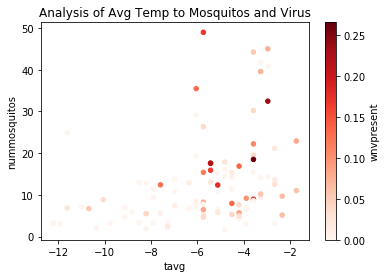

In [131]:
# Higher Temperature = More Mosquitos = Higher weightage of WNV Present

fig, ax = plt.subplots()
df_mean.plot.scatter(x='tavg', y='nummosquitos', c='wnvpresent', colormap='Reds', ax=ax)
ax.set_title('Analysis of Avg Temp to Mosquitos and Virus');

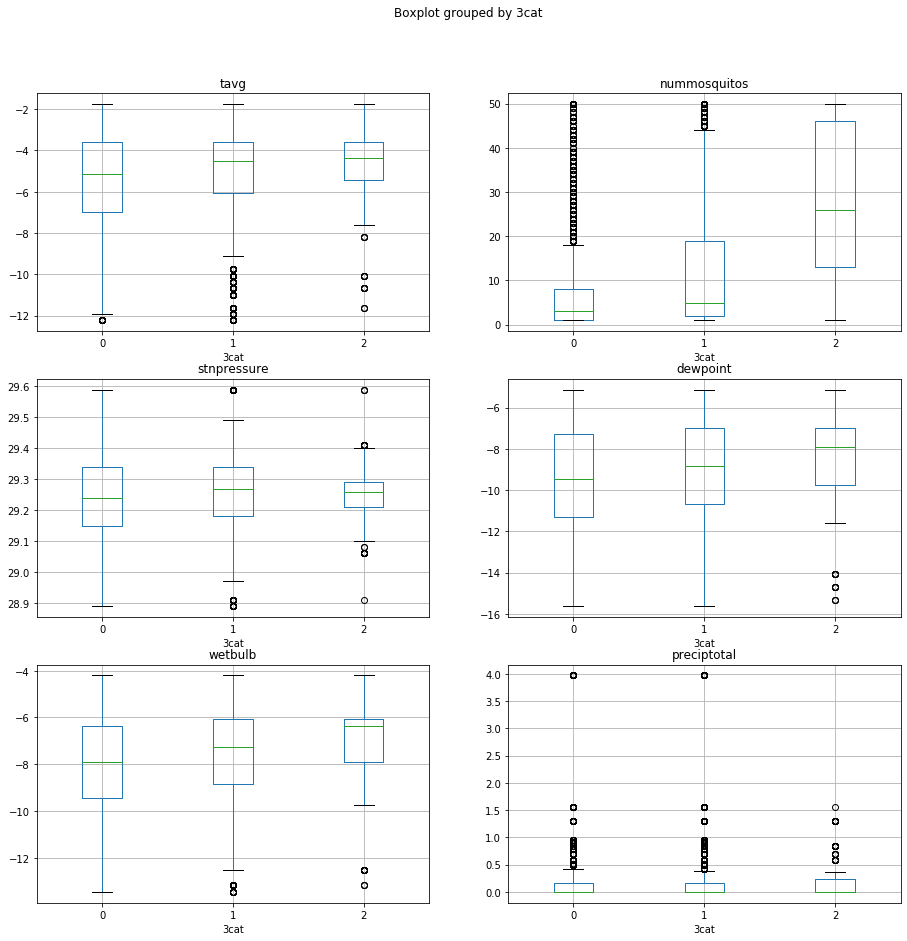

In [132]:
# Category labels:
# 0 [Non-Pipiens & Restuans (Statistically 0 WNV Present)]
# 1 [Pipiens & Restuans with NO WNV]
# 2 [Pipiens & Restuans WITH WNV]

fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(15,15)) 

df.boxplot(column='tavg', by='3cat', ax=axes[0,0]) 
df.boxplot(column='nummosquitos', by='3cat', ax=axes[0,1]) 
df.boxplot(column='stnpressure', by='3cat', ax=axes[1,0]) 
df.boxplot(column='dewpoint', by='3cat', ax=axes[1,1]) 
df.boxplot(column='wetbulb', by='3cat', ax=axes[2,0]) 
df.boxplot(column='preciptotal', by='3cat', ax=axes[2,1]) 

plt.show()

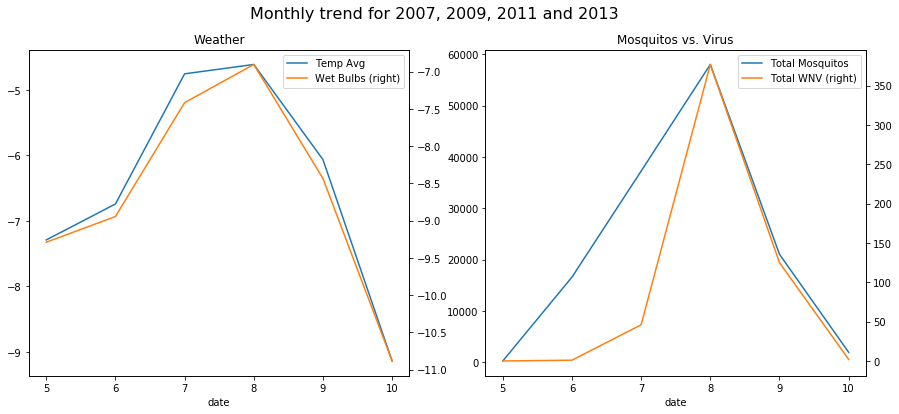

In [133]:
# Month by month analysis for training dataset

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,6))

fig.suptitle("Monthly trend for 2007, 2009, 2011 and 2013", fontsize=16)
df_date_month.tavg.plot(label="Temp Avg", legend=True, ax=axes[0])
df_date_month.wetbulb.plot(secondary_y=True, label="Wet Bulbs", legend=True, ax=axes[0])
axes[0].set_title('Weather')

df_date_month.nummosquitos.plot(label='Total Mosquitos', legend=True,  ax=axes[1]) 
df_date_month.wnvpresent.plot(label='Total WNV', legend=True, ax=axes[1], secondary_y=True)
axes[1].set_title('Mosquitos vs. Virus')

plt.show()

### Bryan Pushing his EDA Here /End

#### Merge df_train by date, followed by by trap

In [186]:
df_train_groupbydate_trap = df_train.groupby(['date','trap'])

In [187]:
def chkWNV(series):
    return 1 if series.sum() > 0 else 0

In [188]:
# Merge by Date, followed by Trap
df_train_bydate_trap = pd.DataFrame(columns=['date', 'address', 'species',
                                             'block', 'street', 'trap',
                                             'addressnumberandstreet',
                                             'latitude', 'longitude',
                                             'addressaccuracy',
                                             'nummosquitos', 'wnvpresent'])

for date_trap, df in df_train_groupbydate_trap:
    df_train_bydate_trap.loc[len(df_train_bydate_trap)] = [date_trap[0],
                                                           np.unique(df['address'])[0],
                                                           np.unique(df['species']),
                                                           np.unique(df['block'])[0],
                                                           np.unique(df['street'])[0],
                                                           date_trap[1], 
                                                           np.unique(df['addressnumberandstreet'])[0], 
                                                           np.unique(df['latitude'])[0],
                                                           np.unique(df['longitude'])[0],
                                                           np.unique(df['addressaccuracy'])[0],
                                                           sum(df['nummosquitos']),
                                                           chkWNV(df['wnvpresent'])]

In [189]:
df_train_bydate_trap.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...","[CULEX PIPIENS/RESTUANS, CULEX RESTUANS]",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,2,0
1,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",[CULEX RESTUANS],62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
2,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA","[CULEX PIPIENS/RESTUANS, CULEX RESTUANS]",79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,5,0
3,2007-05-29,"1500 West Webster Avenue, Chicago, IL 60614, USA",[CULEX RESTUANS],15,W WEBSTER AVE,T045,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8,2,0
4,2007-05-29,"2500 West Grand Avenue, Chicago, IL 60654, USA",[CULEX RESTUANS],25,W GRAND AVE,T046,"2500 W GRAND AVE, Chicago, IL",41.891118,-87.654491,8,1,0


In [190]:
df_train_bydate_trap['species'] = df_train_bydate_trap['species'].apply(','.join)

In [191]:
df_train_bydate_trap['iswnvspecies'] = df_train_bydate_trap['species'].str.contains('PIPIENS|RESTUANS').astype(int)

In [194]:
df_train_bydate_trap.head(2)

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,iswnvspecies
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...","CULEX PIPIENS/RESTUANS,CULEX RESTUANS",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,2,0,1
1,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,1


In [195]:
len(df_train_bydate_trap['trap'].unique())

136

---

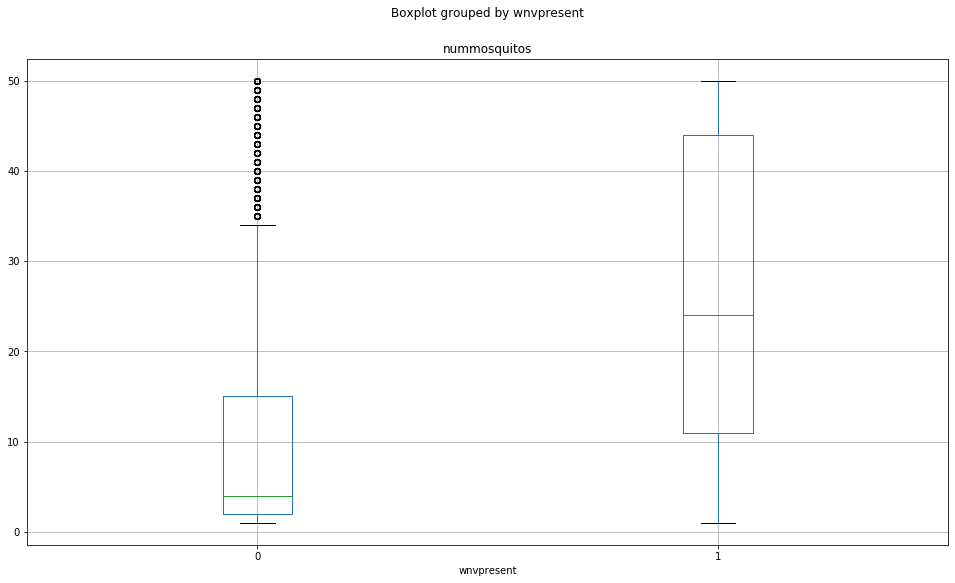

In [196]:
# Number of caught mosquitos by presence of virus
df_train.boxplot(by='wnvpresent',column='nummosquitos',figsize=(16,9));
# Virus is present if number of mosquitos is high

# These test results are organized in such a way that when the number of mosquitos exceed 50, 
# they are split into another record (another row in the dataset), 
# such that the number of mosquitos are capped at 50.

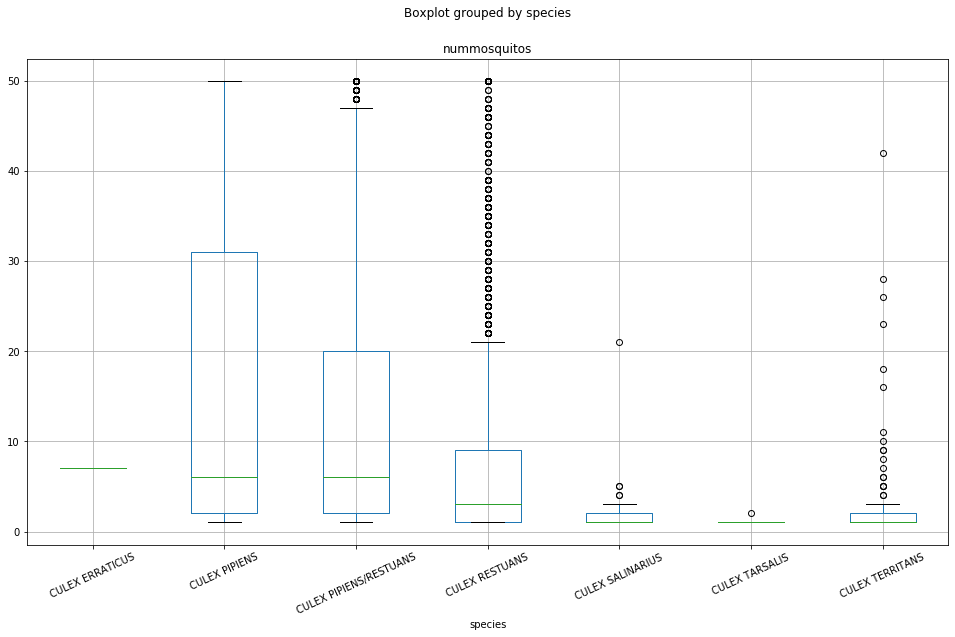

In [197]:
# Number of mosquitos by species of mosquitos
df_train.boxplot(by='species',column='nummosquitos',rot=25, figsize=(16,9));
# 2 species of mosquitos caught much frequently than others - Culex Pipiens and Culex Restuans

# Records exist only when a particular species of mosquitos is found at a certain trap 
# at a certain time. Date: date that the WNV test is performed

In [198]:
# NumMosquitos and WnvPresent by species
df_train.groupby('species')[['nummosquitos','wnvpresent']].sum()
# 2 species cought much frequantly and they contain virus - Also, Culex Pipiens and Culex Restuans
# ? does other species are rare in the area
# ? does it mean that other species can have the virus but due to their rareness we don't see it

,nummosquitos,wnvpresent
species,,
CULEX ERRATICUS,7,0
CULEX PIPIENS,44671,240
CULEX PIPIENS/RESTUANS,66268,262
CULEX RESTUANS,23431,49
CULEX SALINARIUS,145,0
CULEX TARSALIS,7,0
CULEX TERRITANS,510,0


In [199]:
df_train['trap'].value_counts()

T900     750
T115     542
T138     314
T002     185
T135     183
        ... 
T238       7
T094B      5
T076       5
T237       3
T040       2
Name: trap, Length: 136, dtype: int64

In [200]:
df_train['species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: species, dtype: int64

In [201]:
pd.pivot_table(df_train, index='species', values='wnvpresent')

,wnvpresent
species,
CULEX ERRATICUS,0.000000
CULEX PIPIENS,0.088922
CULEX PIPIENS/RESTUANS,0.055135
CULEX RESTUANS,0.017883
CULEX SALINARIUS,0.000000
CULEX TARSALIS,0.000000
CULEX TERRITANS,0.000000


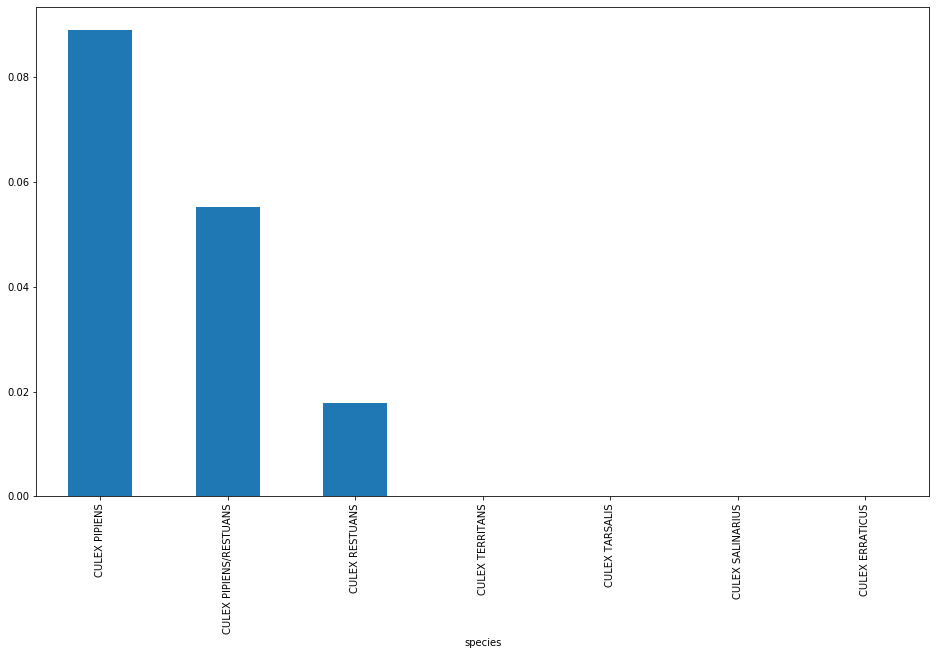

In [202]:
df_train.groupby('species')['wnvpresent'].mean().sort_values(ascending=False).plot.bar(figsize=(16,9));

**Comment**

Based on the above, only mosquitoes which are of the species Culex Pipiens, Culex Pipiens/Restuans and Culex Restuans will carry the West Nile Virus. Therefore, a new boolean feature which indicates whether the mosquitoes caught in each trap are of these few species is created.

In [150]:
# Creating new column which indecates if mosquitoes caught in the trap are those who care the virus
df_train['iswnvspecies'] = df_train['species'].str.contains('PIPIENS|RESTUANS').astype(int)
df_test['iswnvspecies'] = df_test['species'].str.contains('PIPIENS|RESTUANS').astype(int)

In [151]:
# Get top 10 traps with highest occurance of West Nile Virus
top10 = df_train.groupby('trap')['wnvpresent','nummosquitos'].mean().sort_values(by='wnvpresent',ascending=False)
top10.head(10)

C:\Users\anpej\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,wnvpresent,nummosquitos
trap,,
T143,0.193548,7.419355
T006,0.166667,4.458333
T005,0.142857,3.571429
T233,0.140000,15.160000
T014,0.133333,12.133333
T096,0.120000,11.560000
T003,0.114754,11.032787
T015,0.114286,4.828571
T235,0.112903,8.983871


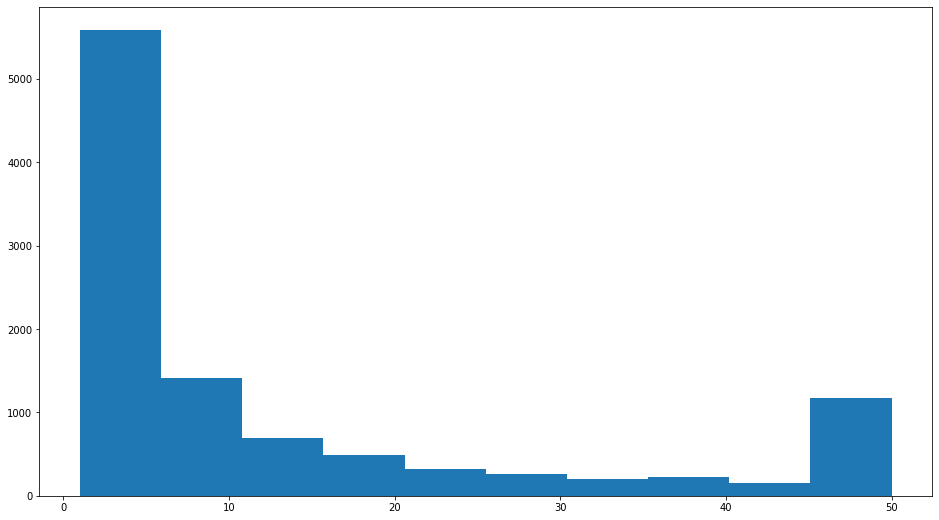

In [152]:
plt.figure(figsize=(16,9))
plt.hist(data=df_train,x='nummosquitos');

### EDA - Combined dataset

In [153]:
# Creating a new column is_spray and setting all cells as False
df_train['is_spray'] = False
df_test['is_spray'] = False

In [155]:
# Very slow cell,change on to False if do now want to run it
# Setting time delta as 30 days. The spray lasts
# A typical mosquito treatment lasts about 30 days. 
# https://www.callnorthwest.com/2019/05/how-long-does-a-mosquito-treatment-last/
on=True
if on:
    tdelta_min = dt.timedelta(days=0)
    tdelta_max = dt.timedelta(days=30)
    for df in [df_train,df_test]:
        # Looping through df with min,max latitudes and longitudes
        for i,spray in min_max_spray.iterrows():
            long_min = spray['longitude_min']
            long_max = spray['longitude_max']
            lat_min = spray['latitude_min']
            lat_max = spray['latitude_max']
        # Looping through train df, checking is latitudes and longitudes lay between min and max
        # and date is the same date or date +30 days of spraying 
            for j,row in df.iterrows():
                if (tdelta_min < (row['date']-spray['date']) <=tdelta_max):
                    if ((lat_min <= row['latitude'] <= lat_max) &
                        (long_min <= row['longitude'] <= long_max)):
                        df_train.loc[j,'is_spray'] = True

In [156]:
# Checking number of rows in train which were sprayed - train
df_train['is_spray'].value_counts()
# Checking number of rows in train which were sprayed - test
df_test['is_spray'].value_counts()

False    116293
Name: is_spray, dtype: int64

In [157]:
# Merging weather and train df
main_df = pd.merge(df_train,df_weather_st1, on=['date','year','month','day'])
main_df_test = pd.merge(df_test,df_weather_st1, on=['date','year','month','day'])

In [158]:
main_df.isnull().sum()

date                      0
address                   0
species                   0
block                     0
street                    0
trap                      0
addressnumberandstreet    0
latitude                  0
longitude                 0
addressaccuracy           0
nummosquitos              0
wnvpresent                0
day                       0
month                     0
year                      0
iswnvspecies              0
is_spray                  0
station                   0
tmax                      0
tmin                      0
tavg                      0
depart                    0
dewpoint                  0
wetbulb                   0
heat                      0
cool                      0
sunrise                   0
sunset                    0
codesum                   0
depth                     0
snowfall                  0
preciptotal               0
stnpressure               0
sealevel                  0
resultspeed               0
resultdir           

In [159]:
# Saving clean datasets
main_df.to_csv('../datasets/main_df.csv',index=False)
main_df_test.to_csv('../datasets/main_df_test.csv',index=False)

# For fuster perfomance of the notebook do not run all the cells above, just upload clean Datasets (train and test)

In [203]:
# Uploading clean datasets
main_df = pd.read_csv('../datasets/main_df.csv')
main_df_test = pd.read_csv('../datasets/main_df_test.csv')
# Changing date columns to datetime type
main_df['date'] = pd.to_datetime(main_df['date'])
main_df_test['date'] = pd.to_datetime(main_df_test['date'])

## Continuation of EDA

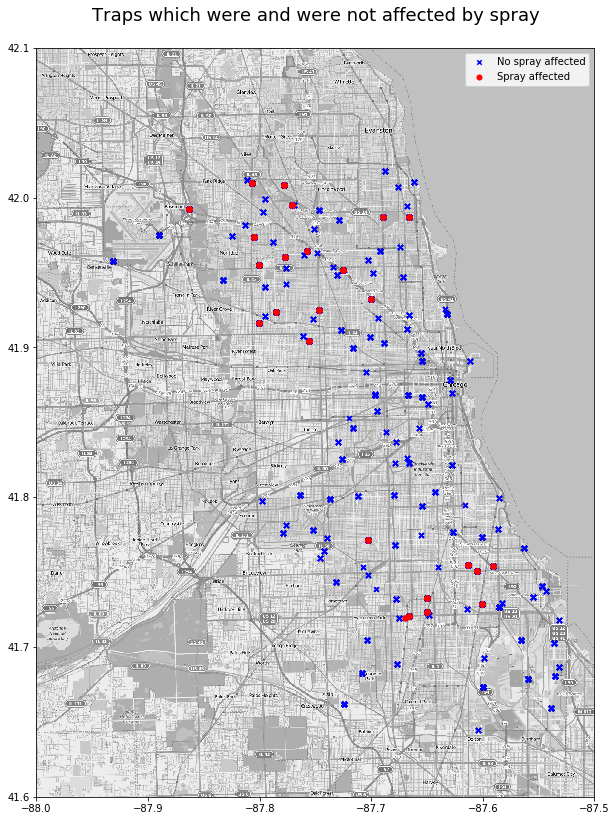

In [204]:
# Plotting traps which were and were not affected by spray
spray_traps = main_df[main_df['is_spray']==True]
spray_no_traps = main_df[main_df['is_spray']==False]

lats_spray = spray_traps['latitude']
longs_spray = spray_traps['longitude']
lats_no_spray = spray_no_traps['latitude']
longs_no_spray = spray_no_traps['longitude']

f.gen_map()

plt.scatter(x=longs_no_spray, y=lats_no_spray, c='b', s=20, marker='x',label='No spray affected')
plt.scatter(x=longs_spray, y=lats_spray, c='r', s=25,label='Spray affected')
plt.title('Traps which were and were not affected by spray\n',fontsize=18)
plt.legend()
plt.show();

**Comment**

From the map above it is seen that only some areas were affected by spray.

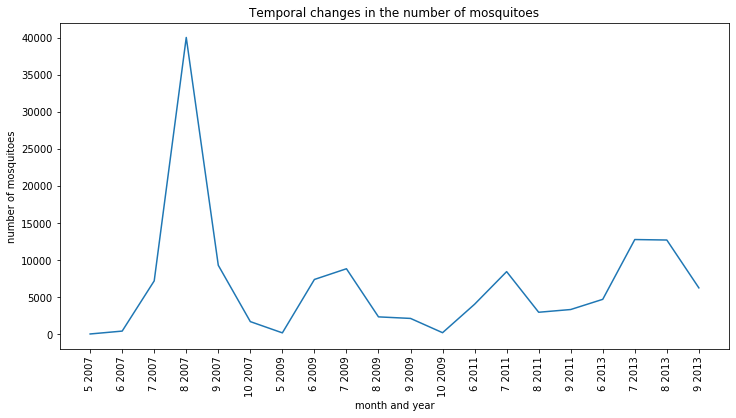

In [208]:
# Visualisation of temporal trend of number of mosquitoes 
main_df['month'] = main_df['date'].map(lambda x: x.month)
num_mosq_month = main_df.groupby(['year','month'])['nummosquitos'].sum().reset_index(level=[0,1])
plt.figure(figsize=(12,6))
plt.plot(num_mosq_month['nummosquitos'])
plt.xticks(range(len(num_mosq_month)),
labels=list(num_mosq_month['month'].astype('str')+' '+num_mosq_month['year'].astype('str')),
          rotation='vertical')
plt.title('Temporal changes in the number of mosquitoes')
plt.ylabel('number of mosquitoes')
plt.xlabel('month and year');

**Comment**

From the linegraph it can be seen that the train dataset contain information only about 5th,6th,7th,8th,9th and 10th months of 2007,2009,2011 and 2013 years.

The biggest numbers of mosquitoes are in 7th and 8th each year.

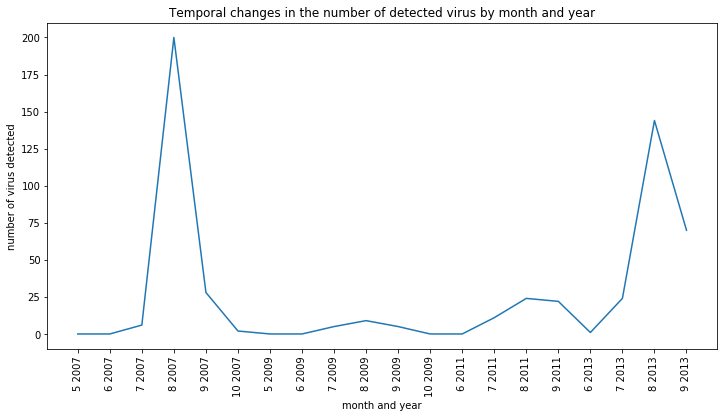

In [209]:
# Plot total count of traps with virus per month over time
num_mosq_month = main_df.groupby(['year','month'])['wnvpresent'].sum().reset_index(level=[0,1])
plt.figure(figsize=(12,6))
plt.plot(num_mosq_month['wnvpresent'])
plt.xticks(range(len(num_mosq_month)),
labels=list(num_mosq_month['month'].astype('str')+' '+num_mosq_month['year'].astype('str')),
          rotation='vertical')
plt.title('Temporal changes in the number of detected virus by month and year')
plt.ylabel('number of virus detected')
plt.xlabel('month and year');

**Comment**

The linegraph illustrate that high number of virus was detected in month 8.

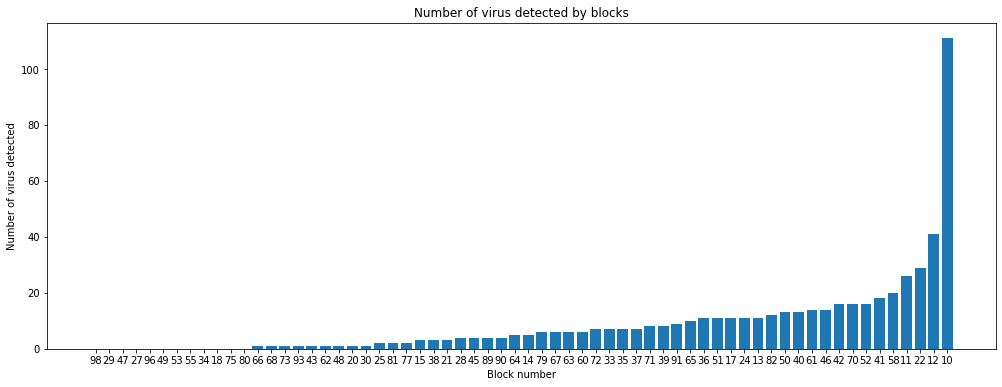

In [210]:
# Plotting presence of the virus on each block
plt.figure(figsize=(17,6))
block_virus = main_df.groupby('block')['wnvpresent'].sum().sort_values()
plt.bar(range(len(main_df['block'].unique())), block_virus)
plt.xlabel('Block number')
plt.ylabel('Number of virus detected')
plt.title('Number of virus detected by blocks')
plt.xticks(range(len(main_df['block'].unique())),labels=block_virus.index);

**Comment**

The bar graph showed that in traps located in block 10, the virus was detected much frequently than in other locations.

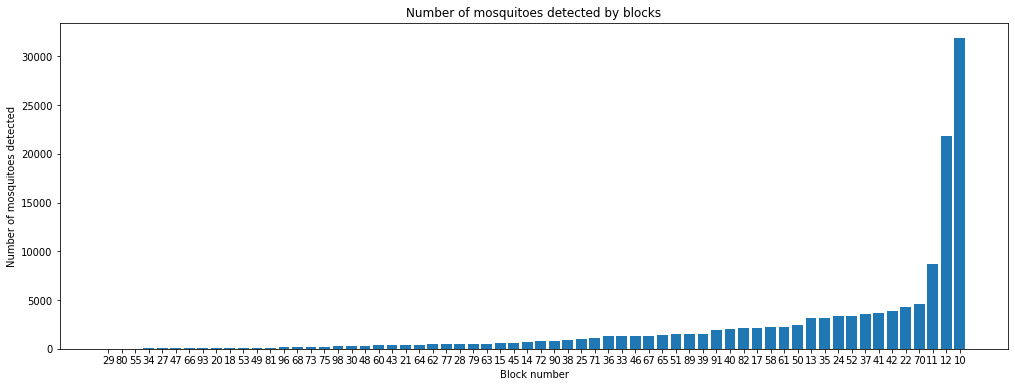

In [211]:
# Plotting number of mosquitoes caught on each block
plt.figure(figsize=(17,6))
plt.bar(range(len(main_df['block'].unique())), main_df.groupby('block')['nummosquitos'].sum().sort_values())
plt.xlabel('Block number')
plt.ylabel('Number of mosquitoes detected')
plt.title('Number of mosquitoes detected by blocks')
plt.xticks(range(len(main_df['block'].unique())),
           labels=main_df.groupby('block')['nummosquitos'].sum().sort_values().index);

**Comment**

It can be seen that 10th amf 12th block have the anomaly high number of virus detected and number of mosquitoes.

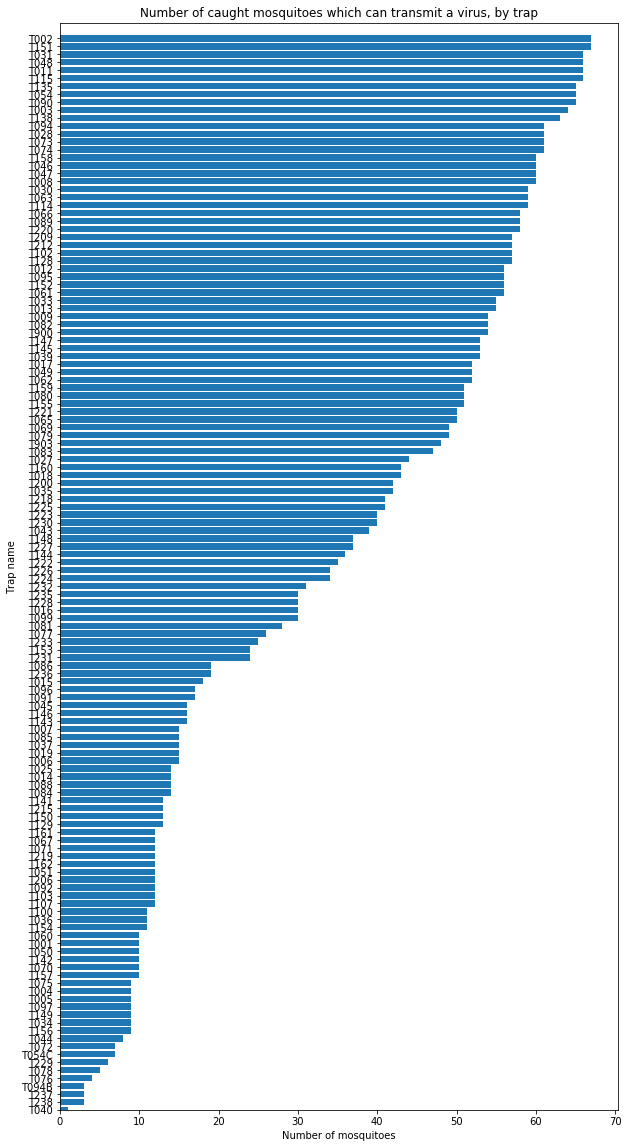

In [212]:
# number of mosquitoes species carry a virus by traps
bin = np.arange(137)
plt.figure(figsize=(10,20))
grouped = df_train_bydate_trap.groupby('trap')['iswnvspecies'].sum()
grouped.sort_values(inplace=True)
plt.barh(grouped.index,grouped.values)
plt.yticks(range(len(grouped.index)),labels=grouped.index)
plt.ylim([0,bin.size])
plt.title('Number of caught mosquitoes which can transmit a virus, by trap')
plt.xlabel('Number of mosquitoes')
plt.ylabel('Trap name');

**Comment**

It can be seen that some traps caught more mosquitoes than others.

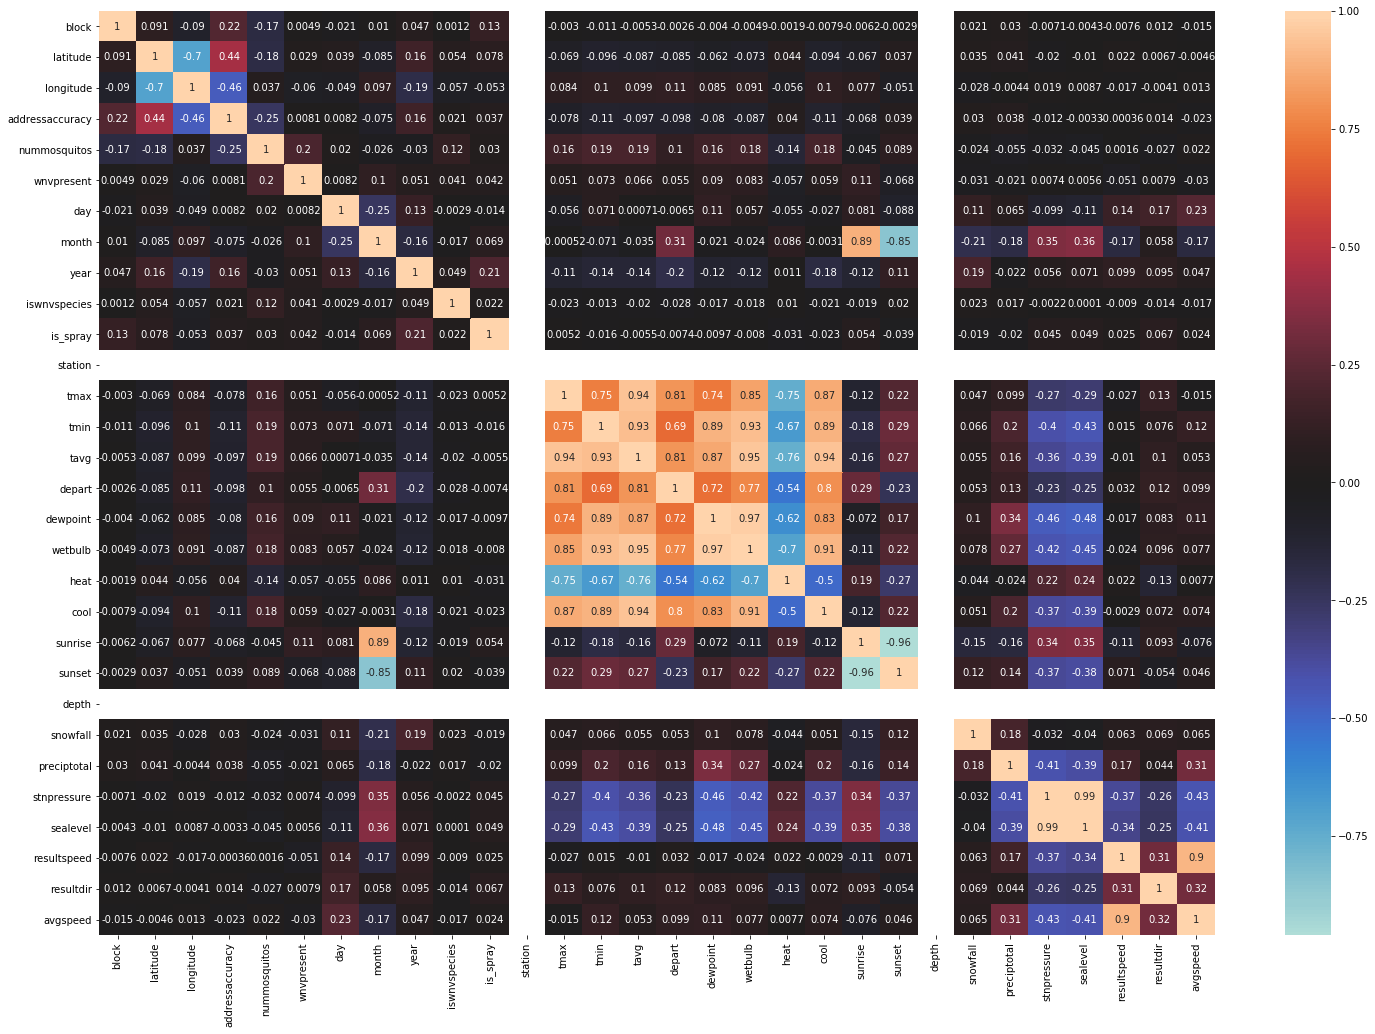

In [213]:
# Plotting intercorrelational matrix
plt.figure(figsize=(25,17))
sns.heatmap(main_df.corr(),annot=True,center=0);

**Comment**

We can see that there are not any features which correlate with the target variable (wnvpresent). It can be due to categorical type of target variable and further research is required. 

It is also noticeable that many of weather features intercorrelate.

In [250]:
# separating rows with detected and undetected virus
false_virus_df = main_df[main_df['wnvpresent']==0]
true_virus_df = main_df[main_df['wnvpresent']==1]

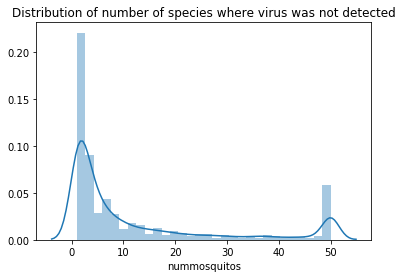

In [215]:
# looking for distribution of number of species where virus was not detected
sns.distplot(false_virus_df['nummosquitos'],bins=30)
plt.title('Distribution of number of species where virus was not detected');

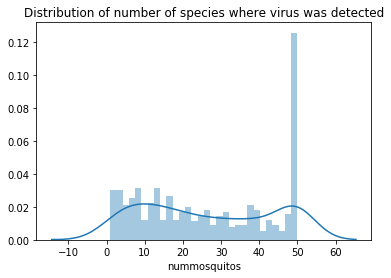

In [695]:
# looking for distribution of number of species where virus was detected
sns.distplot(true_virus_df['nummosquitos'],bins=30)
plt.title('Distribution of number of species where virus was detected');

**Comment**

Two distribution plots showed that if the virus is not present - number of mosquities mostly between 0 and 10. But is the virus is present - number of mosquitoes closer to 50.

In [267]:
# Describtion of those cells where the virus is and is not present
false_virus_df_descr = false_virus_df.describe().T.loc[:,['count','mean','std','min','max','50%']]
true_virus_df_descr = true_virus_df.describe().T.loc[:,['count','mean','std','min','max','50%']]
false_virus_df_descr.columns = [col + '_no' for col in false_virus_df_descr.columns]
true_virus_df_descr.columns = [col + '_vir' for col in true_virus_df_descr.columns]
description_df = pd.concat([false_virus_df_descr,true_virus_df_descr],axis=1)
description_df = description_df.reindex(sorted(description_df.columns), axis=1)

description_df

,50%_no,50%_vir,count_no,count_vir,max_no,max_vir,mean_no,mean_vir,min_no,min_vir,std_no,std_vir
block,33.000000,36.000000,9955.0,551.0,98.000000,93.000000,35.659869,36.192377,10.000000,10.000000,24.326517,24.589118
latitude,41.846075,41.903002,9955.0,551.0,42.017430,42.011601,41.840378,41.854891,41.644612,41.644612,0.112269,0.120243
longitude,-87.694259,-87.725057,9955.0,551.0,-87.531635,-87.531635,-87.698538,-87.724663,-87.930995,-87.930995,0.095880,0.104362
addressaccuracy,8.000000,8.000000,9955.0,551.0,9.000000,9.000000,7.816775,7.869328,3.000000,3.000000,1.455860,1.399085
nummosquitos,4.000000,24.000000,9955.0,551.0,50.000000,50.000000,12.106479,26.350272,1.000000,1.000000,15.745767,17.089997
wnvpresent,0.000000,1.000000,9955.0,551.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
day,15.000000,15.000000,9955.0,551.0,31.000000,31.000000,15.324159,15.653358,1.000000,1.000000,8.922370,8.511467
month,8.000000,8.000000,9955.0,551.0,10.000000,10.000000,7.667403,8.147005,5.000000,6.000000,1.083410,0.557743
year,2009.000000,2011.000000,9955.0,551.0,2013.000000,2013.000000,2009.548066,2010.085299,2007.000000,2007.000000,2.323664,2.811338
iswnvspecies,1.000000,1.000000,9955.0,551.0,1.000000,1.000000,0.968358,1.000000,0.000000,1.000000,0.175055,0.000000


From the table above it is clear that some columns nummosquitos, tmin, tmax, dewpoint, wetbulb, heat, cool, sunrise, sunset, preciptotal, avgspeed have different statistics with regards to the presence of the virus.

In [268]:
# Creating a function for adding delay (14 day) weather
def add_tavg_14day(df):
    tdelta = dt.timedelta(days=14)
    df['date_delay'] = df['date'].map(lambda x:x+ tdelta)
    df = pd.merge(df,df_weather_st1[['date','tavg','wetbulb']],left_on='date_delay',right_on='date')
    df.drop(columns=['date_delay','tavg_x','wetbulb_x','date_y'],inplace=True)
    df.rename(columns={'wetbulb_y':'wetbulb','tavg_y':'tavg','date_x':'date'},inplace=True)
    return df

In [269]:
# Applying function for train and test dfs
main_df = add_tavg_14day(main_df)
main_df_test = add_tavg_14day(main_df_test)

In [294]:
# Changing trap name to number
# Function for removing letters and converting to int
def str_to_int(x):
    x = re.sub("[a-zA-Z]", "", x)
    return int(x)
main_df['trap'] = main_df['trap'].map(lambda x: str_to_int(x))
main_df_test['trap'] = main_df_test['trap'].map(lambda x: str_to_int(x))

### ================================

Dealing with imbalanced data

In [295]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (GradientBoostingClassifier, AdaBoostClassifier, 
VotingClassifier, BaggingClassifier,RandomForestClassifier, ExtraTreesClassifier)

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,roc_auc_score

import re
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek


In [296]:
# Baseline model
main_df['wnvpresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: wnvpresent, dtype: float64

In [297]:
main_df.columns

Index(['date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvpresent', 'day', 'month', 'year', 'iswnvspecies',
       'is_spray', 'station', 'tmax', 'tmin', 'depart', 'dewpoint', 'heat',
       'cool', 'sunrise', 'sunset', 'codesum', 'depth', 'snowfall',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed', 'tavg', 'wetbulb'],
      dtype='object')

In [298]:
X_all = main_df[['block', 'trap',
       'wnvpresent', 'month', 'year', 'iswnvspecies',
       'is_spray', 'dewpoint', 'heat',
       'cool','sunset',
       'preciptotal',
       'avgspeed', 'tavg', 'wetbulb']]
X = main_df[['block', 'trap',
       'month', 'year', 'iswnvspecies',
       'is_spray', 'dewpoint', 'heat',
       'cool','sunset',
       'preciptotal',
       'avgspeed', 'tavg', 'wetbulb']]
y = main_df['wnvpresent']
X_test_submit = main_df_test[['block', 'trap',
       'month', 'year', 'iswnvspecies',
       'is_spray', 'dewpoint', 'heat',
       'cool','sunset',
       'preciptotal',
       'avgspeed', 'tavg', 'wetbulb']]

#### Resampling with different methods

In [299]:
# defining minor and major classes
true_virus = X_all[X_all['wnvpresent']==1]
false_virus = X_all[X_all['wnvpresent']==0]

In [300]:
# doing undersampling of the majority class
on=True
if on:
    false_virus_downsampled = resample(false_virus,
                                    replace = False, # sample without replacement
                                    n_samples = len(true_virus), # match minority n
                                    random_state = 42) # reproducible results

    # combine minority and downsampled majority
    downsampled = pd.concat([false_virus_downsampled, true_virus])
    features = [col for col in downsampled if col !='wnvpresent']
    X_unders = downsampled[features]
    y_unders = downsampled['wnvpresent']
    # checking counts
    downsampled.wnvpresent.value_counts()

In [301]:
# Doing oversempling the minority class
# https://www.kaggle.com/tboyle10/methods-for-dealing-with-imbalanced-data
# Separate input features and target

on=True
if on:
    sm = SMOTE(sampling_strategy='minority',random_state=42)
    X_train_sm, y_train_sm = sm.fit_sample(X, y)
    oversempling_smote = pd.concat([X_train_sm, y_train_sm],axis=1)
    oversempling_smote.wnvpresent.value_counts()


In [302]:
# a combination of over-sampling and under-sampling
# https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
on=True
if on:
    smt = SMOTETomek(sampling_strategy='auto')
    X_smt, y_smt = smt.fit_sample(X, y)
    oversempling_smoteTomek = pd.concat([X_smt, y_smt],axis=1)
    oversempling_smoteTomek.wnvpresent.value_counts()

In [303]:
# Creating function for resamling
def resampling_dataset(how,X_train,y_train,on=True):
    """
    Resamples imbalanced dataset
    
    Takes:
    how (str) : 'under', 'over', 'smote'
    x - df - with features
    y - series - with target
    on - on/of function
    Returns:
    X,y
    """
    if on:
        if how == 'under':
            X = pd.concat([X_train, y_train])
            true_virus = X[X['wnvpresent']==1]
            false_virus = X[X['wnvpresent']==0]
            false_virus_downsampled = resample(false_virus,
                                    replace = False, # sample without replacement
                                    n_samples = len(true_virus), # match minority n
                                    random_state = 42) # reproducible results

            # combine minority and downsampled majority
            downsampled = pd.concat([false_virus_downsampled, true_virus])
            features = [col for col in downsampled if col !='wnvpresent']
            X_unders = downsampled[features]
            y_unders = downsampled['wnvpresent']
            return X_unders, y_unders
        elif how == 'over':
            sm = SMOTE(sampling_strategy='minority',random_state=42)
            X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
            oversempling_smote = pd.concat([X_train_sm, y_train_sm],axis=1)
            return X_train_sm, y_train_sm
        else:
            smt = SMOTETomek(sampling_strategy='auto')
            X_smt, y_smt = smt.fit_sample(X_train, y_train)
            return X_smt, y_smt

In [312]:
# Creating a function for boxplots
def subplot_boxplot(dataframe, list_columns,maintitle,blocks,figsize=(10,10)):
    """
    Plots a boxplot of the column which in the list. 
    
    Takes:
    dataframe
    list_columns - (list of str) - list of column's names.
    maintitle - (str) - main title for all scatterplots
    figsize - the custom size of a figure, 10x10 by default.
    blocks - (list of int) - list of block names
    
    Returns:
    Boxplot plot.
    """
#     for i_blk in range(2):
#         if i_blk < 2:
#             block_df = dataframe[(dataframe['block']==10)|(dataframe['block']==12)]
#             maintitle_upt = maintitle + f' , block 10,12'
#         else:
#             block_df = dataframe[(dataframe['block']!=10)|(dataframe['block']!=12)]
#             maintitle_upt = maintitle + ' , other blocks.'
    nrows = int(np.ceil(len(list_columns)/3))
    fig, ax = plt.subplots(nrows=nrows, ncols=3,figsize=figsize)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_columns):
        dataframe.boxplot(column=column, 
                    by='wnvpresent', ax=ax[i])
        ax[i].set_title(f'Boxplot of {column}\n', fontsize=20)
#         deleting empty subplot if list_of_list_columns is odd
    if len(list_columns)%2 ==0:
        fig.delaxes(ax[len(list_columns)]) 
    plt.tight_layout(pad=0.4, w_pad=2, h_pad=2)
    plt.suptitle(maintitle,fontsize=25)
    fig.subplots_adjust(top=0.95)
    plt.show()

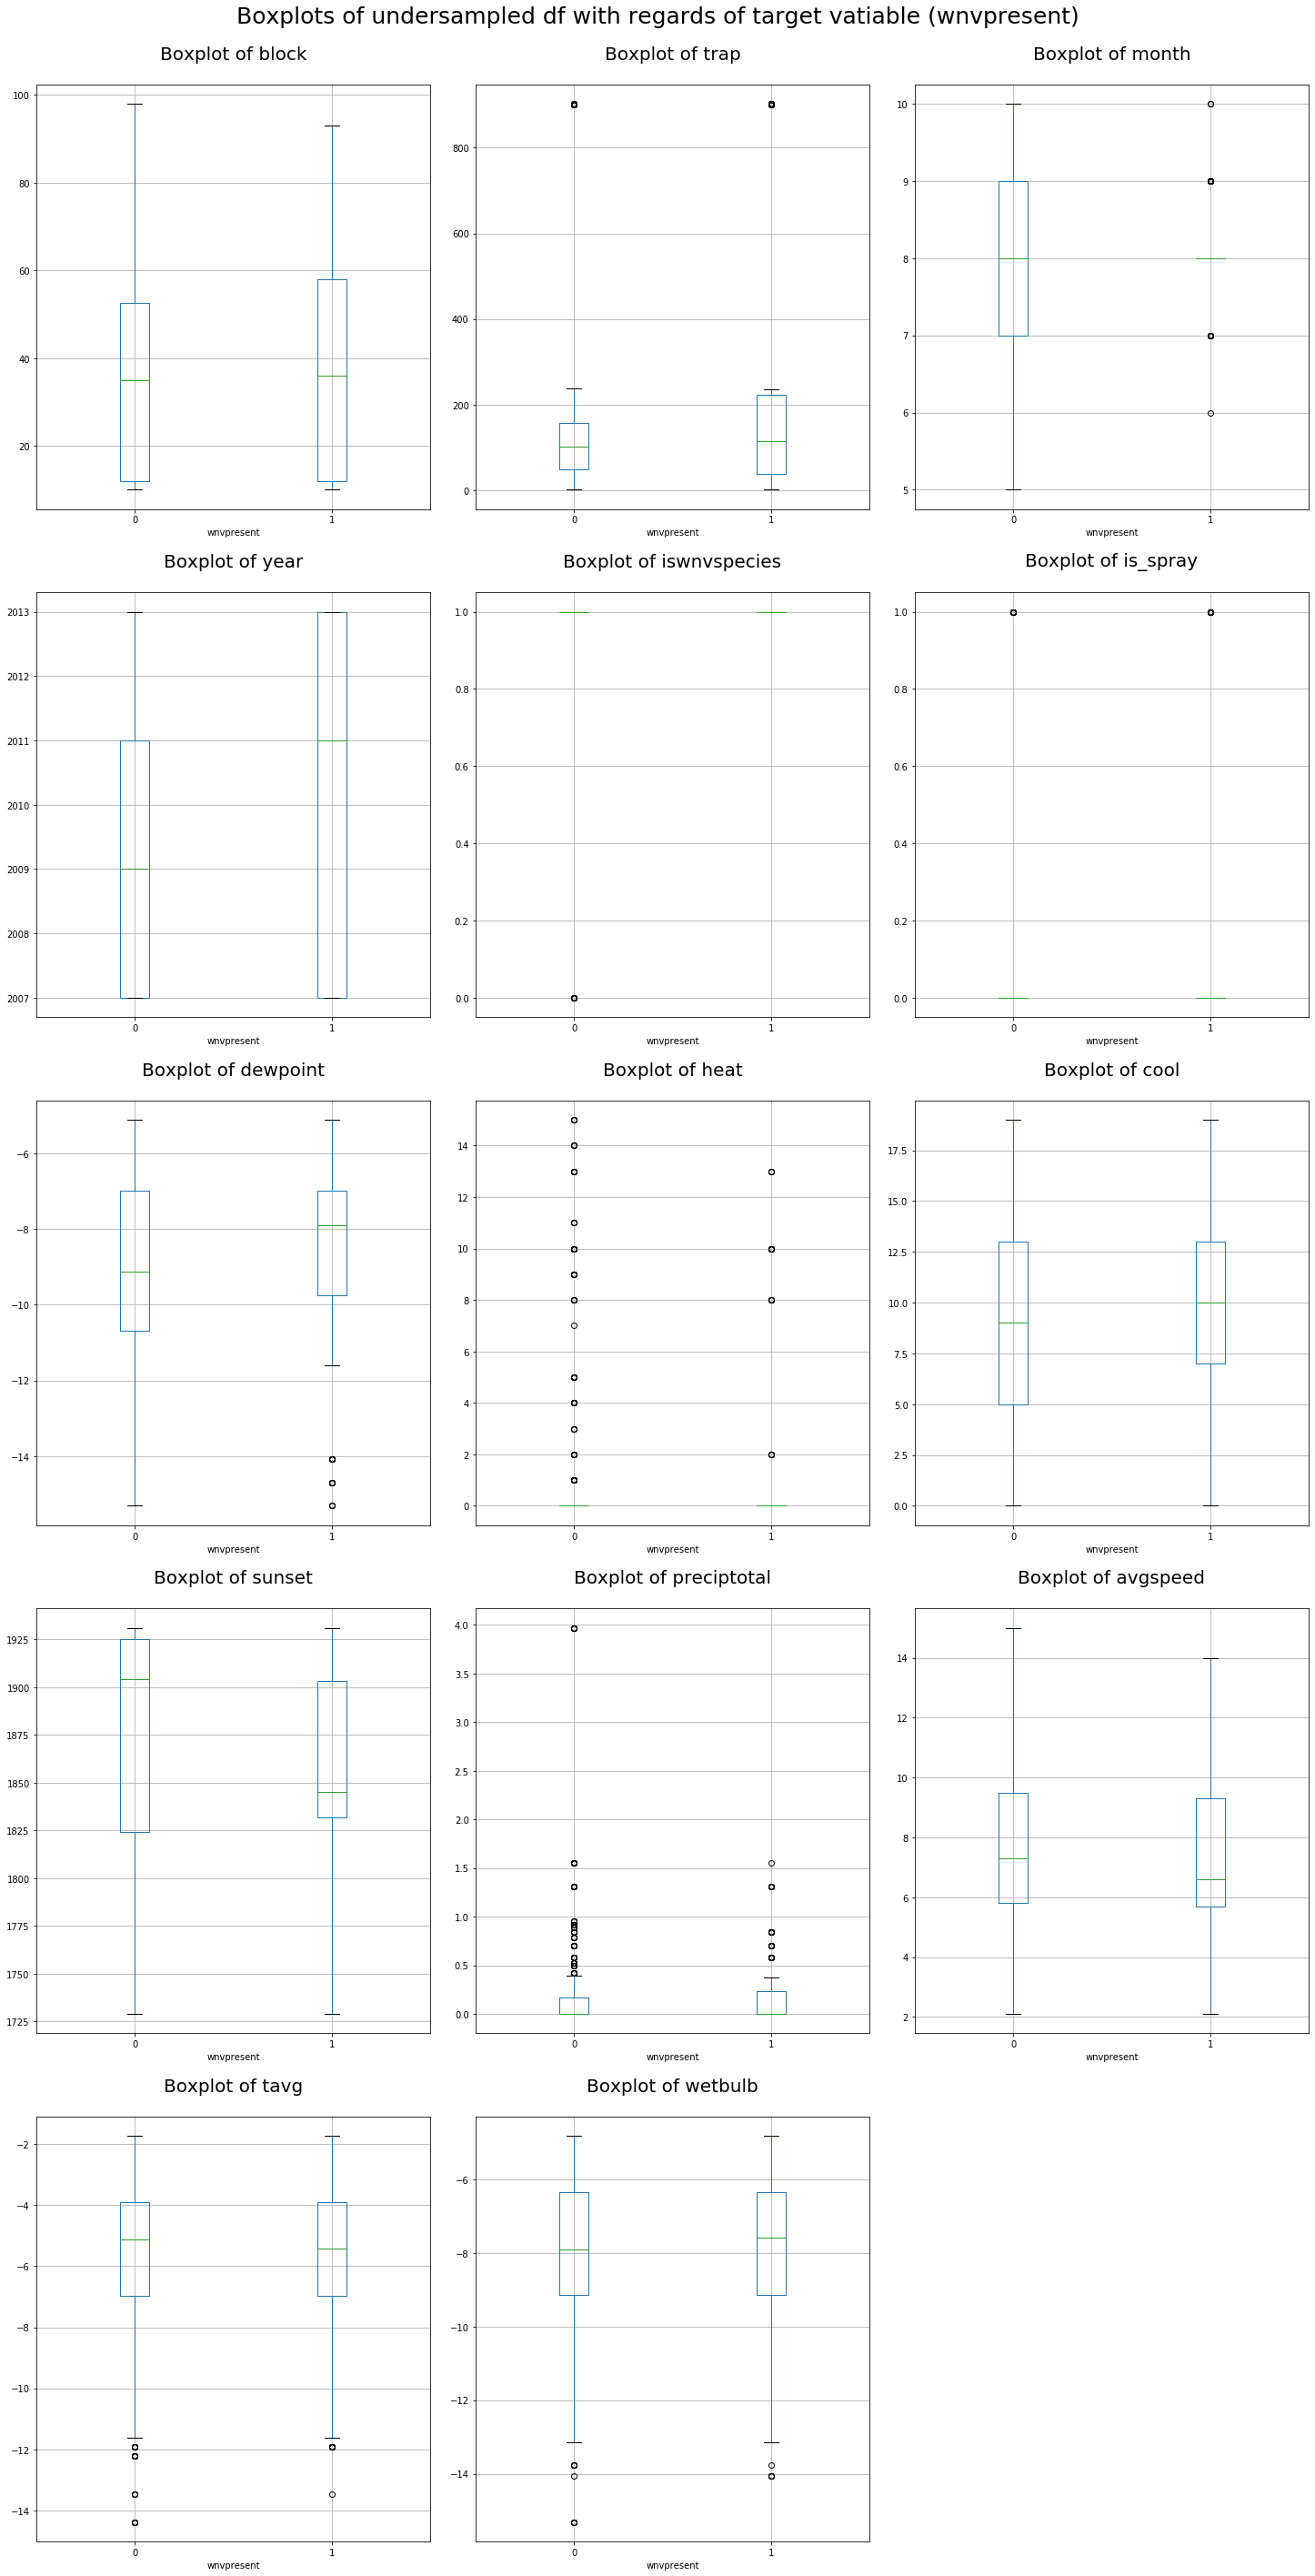

In [314]:
# boxplots of undersampeled data by virus column
# looking for different distribution of features by virus present
maintitle = 'Boxplots of undersampled df with regards of target vatiable (wnvpresent)'
subplot_boxplot(downsampled, X_unders.columns,maintitle,blocks=[10,12],figsize=(20,40))

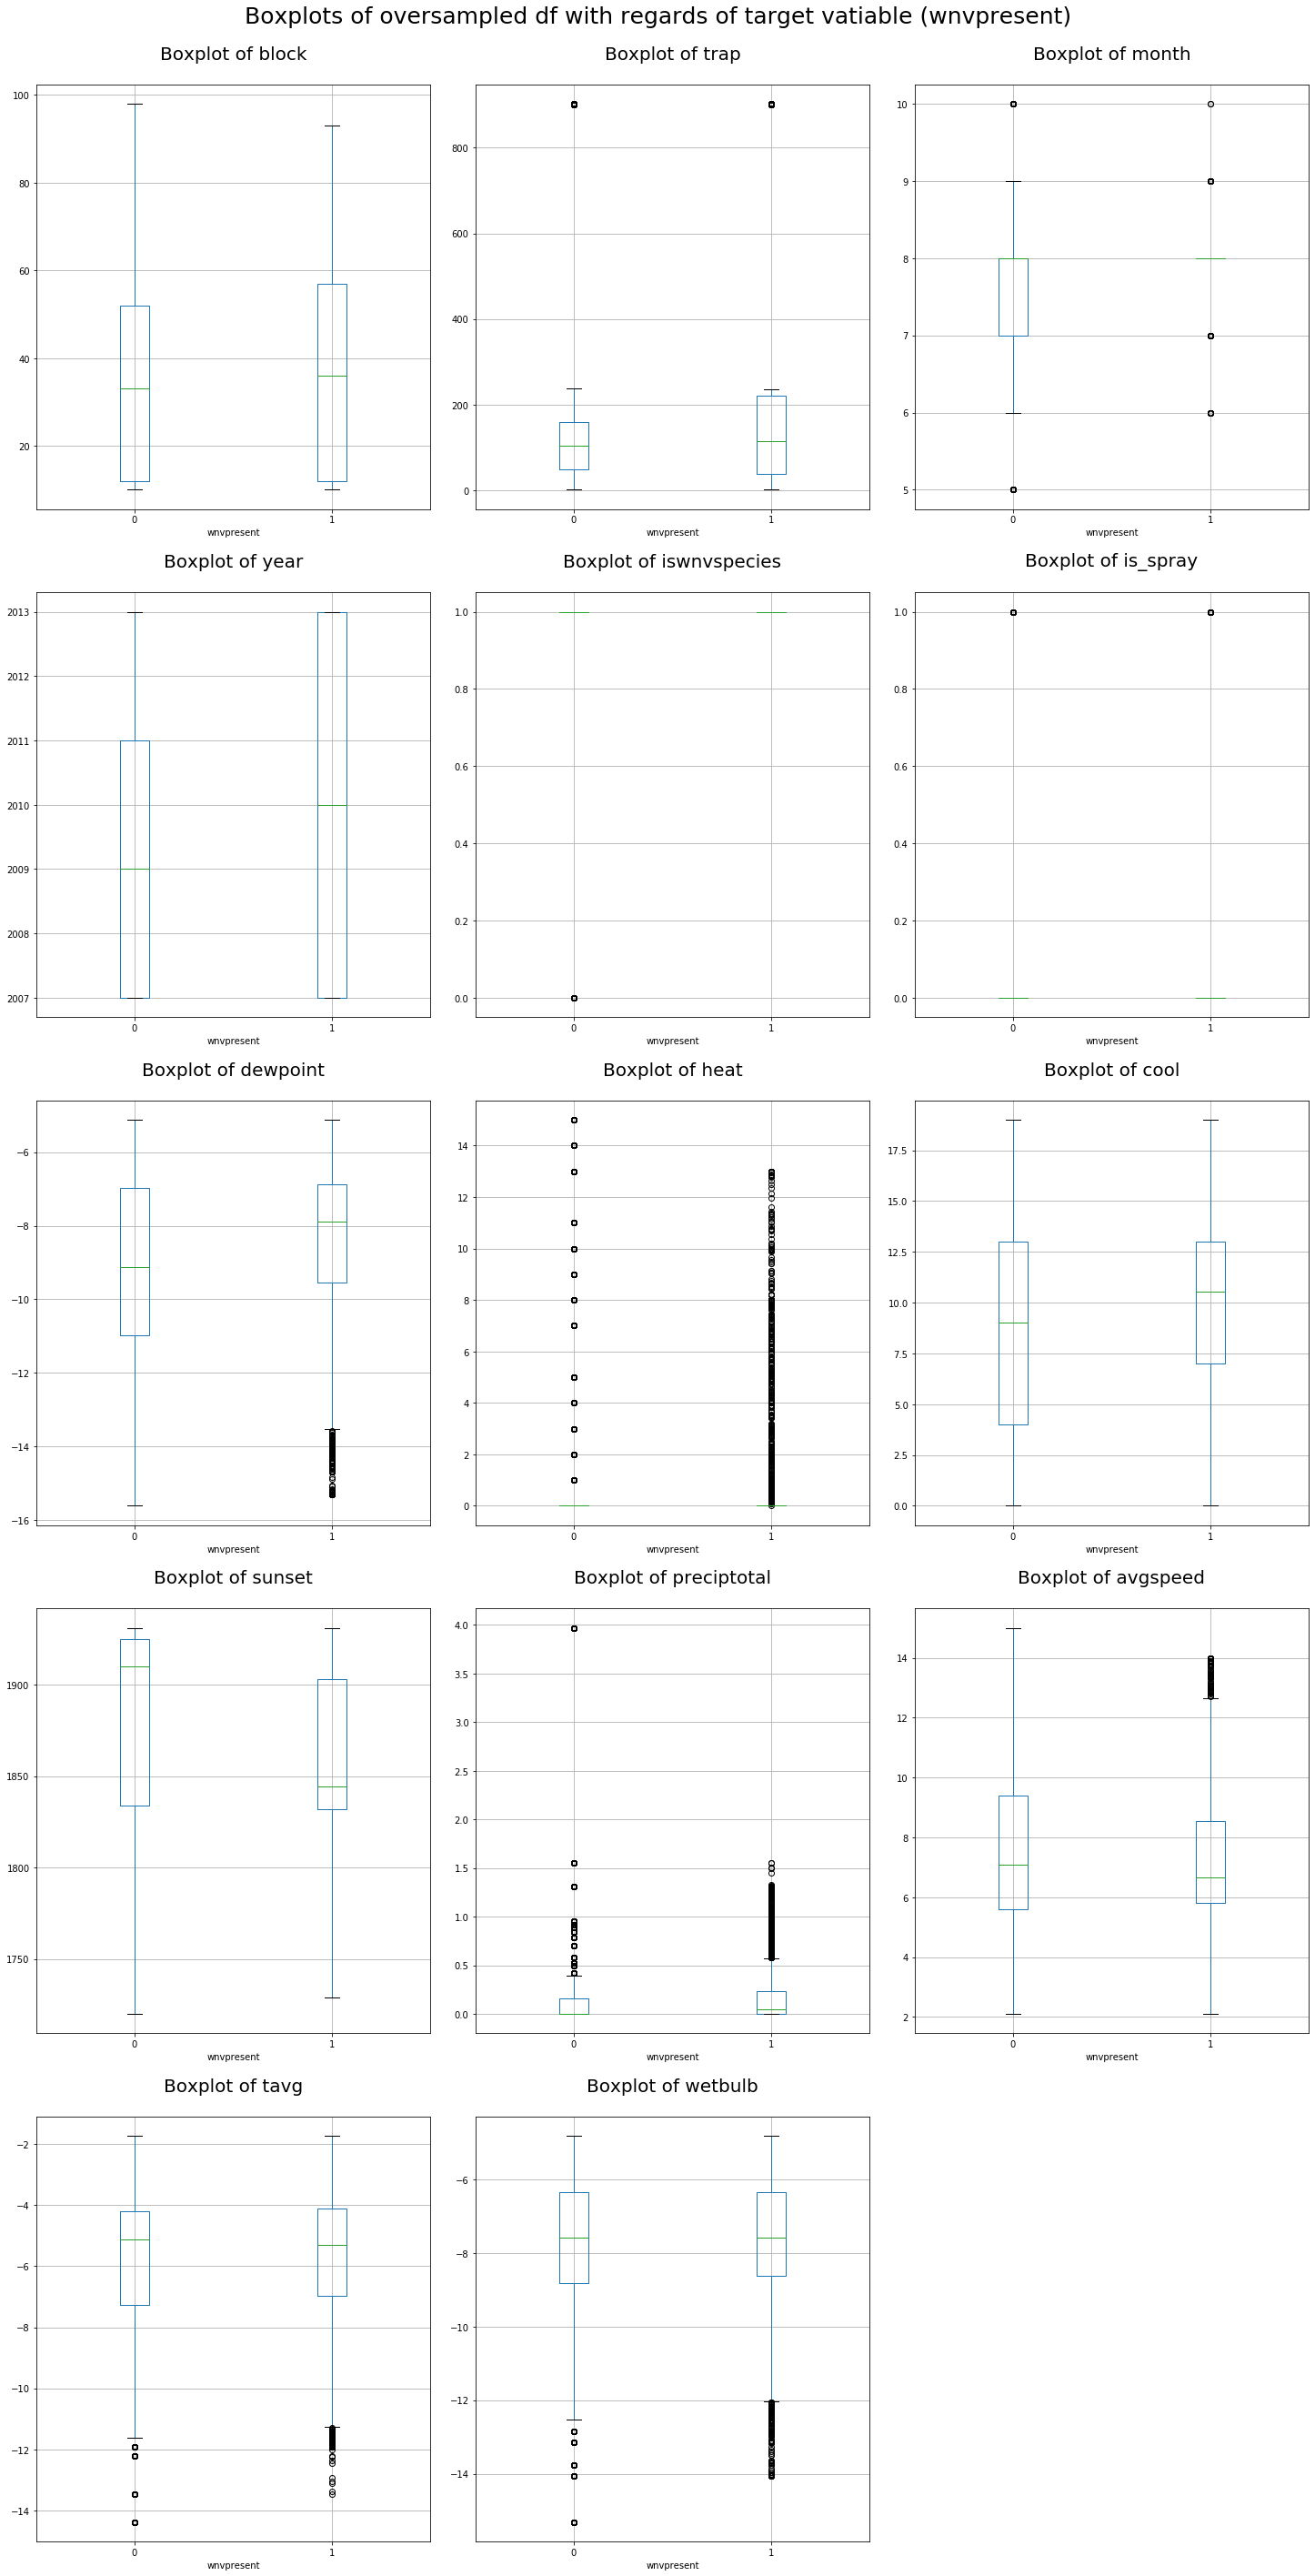

In [315]:
# boxplots of oversampeled data by virus column
# looking for different distribution of features by virus present
maintitle = 'Boxplots of oversampled df with regards of target vatiable (wnvpresent)'
subplot_boxplot(oversempling_smote, X_train_sm.columns,maintitle,blocks=[10,12],figsize=(20,40))

**Comment**

The difference between classes of the target variable (the presence of the virus) is not very distinct.

Next step is to check the performance of 5 models on the 3 new datasets with resampling.

In [316]:
# Creating function for simple models evaluation
def sample_evaluation(X,y,models,names_samples,on=True):
    if on:
        for i in range(len(X)):
            X_train, X_test, y_train, y_test = train_test_split(X[i],y[i])
            ss = StandardScaler()
            X_train_scaled = ss.fit_transform(X_train)
            X_test_scaled = ss.transform(X_test)
            for model in models:
                cv_scores = cross_val_score(model,X_train_scaled,y_train)
                model.fit(X_train_scaled,y_train)
                train_score = model.score(X_train_scaled,y_train)
                test_score = model.score(X_test_scaled,y_test)
                print(names_samples[i])
                print(str(model).split('(')[0])
                print('CV',cv_scores)
                print('train',train_score)
                print('test',test_score)
                # set of predicted labels match the corresponding set of true labels
                y_predicted = model.predict(X_test_scaled)
                accuracy = accuracy_score(y_test, y_predicted)
                # ratio tp / (tp + fp)
                precision = precision_score(y_test, y_predicted)             
                # ratio tp / (tp + fn)
                recall = recall_score(y_test, y_predicted)
                # weighted average of the precision and recall
                # F1 = 2 * (precision * recall) / (precision + recall)
                f1 = f1_score(y_test, y_predicted)
                tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()
                print("True Negatives: %s" % tn)
                print("False Positives: %s" % fp)
                print("False Negatives: %s" % fn)
                print("True Positives: %s" % tp)
                print(f'accuracy {round(accuracy,3)}, precision {round(precision,3)},recall {round(recall,3)}, f1 {round(f1,3)}')
                print('==================')

In [305]:
# Change on to True to run a function
lr = LogisticRegression()
knn = KNeighborsClassifier()
svm = SVC()
dtree = DecisionTreeClassifier()
randtree = RandomForestClassifier()
sample_evaluation([X_unders, X_train_sm, X_smt],[y_unders, y_train_sm,y_smt],
                  models=[lr,knn,svm,dtree,randtree,],
                  names_samples=['undersampling','oversampling','smote'],
                 on=False)

undersampling
LogisticRegression
CV [0.6746988  0.73333333 0.67878788 0.7030303  0.74545455]
train 0.7106537530266344
test 0.7282608695652174
True Negatives: 90
False Positives: 48
False Negatives: 27
True Positives: 111
accuracy 0.728, precision 0.698,recall 0.804, f1 0.747
undersampling
KNeighborsClassifier
CV [0.69879518 0.6969697  0.70909091 0.75757576 0.69090909]
train 0.7953995157384988
test 0.7572463768115942
True Negatives: 104
False Positives: 34
False Negatives: 33
True Positives: 105
accuracy 0.757, precision 0.755,recall 0.761, f1 0.758
undersampling
SVC
CV [0.70481928 0.71515152 0.71515152 0.75757576 0.74545455]
train 0.7687651331719129
test 0.7536231884057971
True Negatives: 86
False Positives: 52
False Negatives: 16
True Positives: 122
accuracy 0.754, precision 0.701,recall 0.884, f1 0.782
undersampling
DecisionTreeClassifier
CV [0.6746988  0.72727273 0.72121212 0.75757576 0.72121212]
train 0.9564164648910412
test 0.6594202898550725
True Negatives: 88
False Positives: 50

                undersampling
                LogisticRegression
                CV [0.6746988  0.73333333 0.67878788 0.7030303  0.74545455]
                train 0.7106537530266344
                test 0.7282608695652174
                True Negatives: 90
                False Positives: 48
                False Negatives: 27
                True Positives: 111
                accuracy 0.728, precision 0.698,recall 0.804, f1 0.747
                ==================
                undersampling
                KNeighborsClassifier
                CV [0.69879518 0.6969697  0.70909091 0.75757576 0.69090909]
                train 0.7953995157384988
                test 0.7572463768115942
                True Negatives: 104
                False Positives: 34
                False Negatives: 33
                True Positives: 105
                accuracy 0.757, precision 0.755,recall 0.761, f1 0.758
                ==================
                undersampling
                SVC
                CV [0.70481928 0.71515152 0.71515152 0.75757576 0.74545455]
                train 0.7687651331719129
                test 0.7536231884057971
                True Negatives: 86
                False Positives: 52
                False Negatives: 16
                True Positives: 122
                accuracy 0.754, precision 0.701,recall 0.884, f1 0.782
                ==================
                undersampling
                DecisionTreeClassifier
                CV [0.6746988  0.72727273 0.72121212 0.75757576 0.72121212]
                train 0.9564164648910412
                test 0.6594202898550725
                True Negatives: 88
                False Positives: 50
                False Negatives: 44
                True Positives: 94
                accuracy 0.659, precision 0.653,recall 0.681, f1 0.667
                ==================
                undersampling
                RandomForestClassifier
                CV [0.72289157 0.74545455 0.76969697 0.77575758 0.72727273]
                train 0.9564164648910412
                test 0.7065217391304348
                True Negatives: 93
                False Positives: 45
                False Negatives: 36
                True Positives: 102
                accuracy 0.707, precision 0.694,recall 0.739, f1 0.716
                ==================
                oversampling
                LogisticRegression
                CV [0.69266823 0.70438567 0.68955124 0.70997991 0.70026792]
                train 0.7002410929547281
                test 0.7016874246685416
                True Negatives: 1617
                False Positives: 902
                False Negatives: 583
                True Positives: 1876
                accuracy 0.702, precision 0.675,recall 0.763, f1 0.716
                ==================
                oversampling
                KNeighborsClassifier
                CV [0.90257784 0.90659525 0.89986604 0.90087073 0.90622907]
                train 0.9313554781676936
                test 0.9031739654479711
                True Negatives: 2246
                False Positives: 273
                False Negatives: 209
                True Positives: 2250
                accuracy 0.903, precision 0.892,recall 0.915, f1 0.903
                ==================
                oversampling
                SVC
                CV [0.82457315 0.83963843 0.81212324 0.82518419 0.83188212]
                train 0.8341146530940262
                test 0.8256327842507031
                True Negatives: 1959
                False Positives: 560
                False Negatives: 308
                True Positives: 2151
                accuracy 0.826, precision 0.793,recall 0.875, f1 0.832
                ==================
                oversampling
                DecisionTreeClassifier
                CV [0.93036491 0.93304319 0.92498326 0.92866711 0.93067649]
                train 0.9607554245914813
                test 0.9381277621534753
                True Negatives: 2356
                False Positives: 163
                False Negatives: 145
                True Positives: 2314
                accuracy 0.938, precision 0.934,recall 0.941, f1 0.938
                ==================
                oversampling
                RandomForestClassifier
                CV [0.93973887 0.9390693  0.93134628 0.93469524 0.93670462]
                train 0.9607554245914813
                test 0.9433507432703897
                True Negatives: 2357
                False Positives: 162
                False Negatives: 120
                True Positives: 2339
                accuracy 0.943, precision 0.935,recall 0.951, f1 0.943
                ==================
                smote
                LogisticRegression
                CV [0.70241287 0.71102917 0.69761985 0.69795508 0.69862554]
                train 0.7056851702869402
                test 0.6985116653258246
                True Negatives: 1605
                False Positives: 940
                False Negatives: 559
                True Positives: 1868
                accuracy 0.699, precision 0.665,recall 0.77, f1 0.714
                ==================
                smote
                KNeighborsClassifier
                CV [0.90650134 0.90211197 0.89909487 0.89607777 0.89875964]
                train 0.9329578975596675
                test 0.9024537409493162
                True Negatives: 2251
                False Positives: 294
                False Negatives: 191
                True Positives: 2236
                accuracy 0.902, precision 0.884,recall 0.921, f1 0.902
                ==================
                smote
                SVC
                CV [0.82808311 0.8364063  0.82500838 0.83674154 0.82165605]
                train 0.8366183963529096
                test 0.8211987127916331
                True Negatives: 1952
                False Positives: 593
                False Negatives: 296
                True Positives: 2131
                accuracy 0.821, precision 0.782,recall 0.878, f1 0.827
                ==================
                smote
                DecisionTreeClassifier
                CV [0.9286193  0.92993631 0.93362387 0.92524304 0.91786792]
                train 0.9609814963797265
                test 0.9316170555108608
                True Negatives: 2361
                False Positives: 184
                False Negatives: 156
                True Positives: 2271
                accuracy 0.932, precision 0.925,recall 0.936, f1 0.93
                ==================
                smote
                RandomForestClassifier
                CV [0.93331099 0.94032853 0.9359705  0.93429433 0.93027154]
                train 0.9609814963797265
                test 0.9366452131938857
                True Negatives: 2331
                False Positives: 214
                False Negatives: 101
                True Positives: 2326
                accuracy 0.937, precision 0.916,recall 0.958, f1 0.937
                ==================

The models above illustrated that oversampling showing better results than undersampling or combination of over and undersampling. Preliminary, KNeighborsClassifier, DecisionTreeClassifier and RandomForestClassifier got better scores than LogisticRegression and SVC.

Next step is tune hyperparameters of models with gridsearch.

In [317]:
# Creating function for models evaluation with gridsearch parameters
def sample_evaluation_grid(X,y,models,params,names_samples,on=True):
    """
    Use different resample and different ML models to evaluate perfomance with gridsearch
    Takes:
    X - list of resampled X
    y - list of resampled y
    params - list of hyperparameters for gridsearch
    name_samples - list of str - name of resampling technique
    
    Prints accoracy score on train and test data
    """
    if on:
        for i in range(len(X)):
            X_train, X_test, y_train, y_test = train_test_split(X[i],y[i])
            ss = StandardScaler()
            X_train_scaled = ss.fit_transform(X_train)
            X_test_scaled = ss.transform(X_test)
            for j, model in enumerate(models):
                grid = GridSearchCV(model,param_grid=params[j])
                cv_scores = cross_val_score(grid,X_train_scaled,y_train)
                grid.fit(X_train,y_train)
                best_model = grid.best_estimator_
                best_model.fit(X_train_scaled,y_train)
                train_score = best_model.score(X_train_scaled,y_train)
                test_score = best_model.score(X_test_scaled,y_test)
                print(names_samples[i])
                print(str(model).split('(')[0])
                print(grid.best_params_)
                print('CV',cv_scores)
                print('train',train_score)
                print('test',test_score)
                print('==================')
                # set of predicted labels match the corresponding set of true labels
                y_predicted = best_model.predict(X_test_scaled)
                accuracy = accuracy_score(y_test, y_predicted)
                # ratio tp / (tp + fp)
                precision = precision_score(y_test, y_predicted)             
                # ratio tp / (tp + fn)
                recall = recall_score(y_test, y_predicted)
                # weighted average of the precision and recall
                # F1 = 2 * (precision * recall) / (precision + recall)
                f1 = f1_score(y_test, y_predicted)
                tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()
                print("True Negatives: %s" % tn)
                print("False Positives: %s" % fp)
                print("False Negatives: %s" % fn)
                print("True Positives: %s" % tp)
                print(f'accuracy {round(accuracy,3)}, precision {round(precision,3)},recall {round(recall,3)}, f1 {round(f1,3)}')
                print('==================')

In [318]:
# Based on the above the oversampling method was chosen
# Creating an oversample df using a function written above
X,y = resampling_dataset('over',X,y,on=True)

In [320]:
# Change on to True to run a function
# Using function for models evaluation with gridsearch

lr = LogisticRegression(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
svm = SVC()
dtree = DecisionTreeClassifier()
randtree = RandomForestClassifier(n_jobs=-1)


sample_evaluation_grid([X],[y],
models=[lr,knn,svm,dtree,randtree,],names_samples=['oversampling'],
params = [{'penalty':['l2','none'],'tol':[0.0001,0.001],'max_iter':[500,700]},
         {'n_neighbors':[3,5,7], 'weights':['uniform','distance']},
         {'degree':[1,3,6], 'C':[0.1,0.3,1]},
        {'max_depth':[None,2,4],'min_samples_leaf':[1,2,3]},
        {'n_estimators':[80,100,120],'max_depth':[None,2,4],'min_samples_leaf':[1,2,3]}],
                       on=False)



#         'tree__max_depth':[None,2,4],
#         'tree__min_samples_leaf':[1,2,3],
#         'randomtree__max_depth':[None,2,4],
#         'tree__min_samples_leaf':[1,2,3],
#         'gradboost__max_depth':[4,5], 
#         'gradboost__n_estimators':[100,125],
#         'gradboost__learning_rate':[0.1,0.3,0.5],


oversampling
LogisticRegression
{'max_iter': 700, 'penalty': 'none', 'tol': 0.0001}
CV [0.68429863 0.70840308 0.69993302 0.70361688 0.70060281]
train 0.6989016876506831
test 0.691844114102049
True Negatives: 1541
False Positives: 936
False Negatives: 598
True Positives: 1903
accuracy 0.692, precision 0.67,recall 0.761, f1 0.713
oversampling
KNeighborsClassifier
{'n_neighbors': 3, 'weights': 'distance'}
CV [0.92065618 0.90659525 0.91929002 0.91393168 0.91292699]
train 0.9596169300830432
test 0.928887103254319
True Negatives: 2287
False Positives: 190
False Negatives: 164
True Positives: 2337
accuracy 0.929, precision 0.925,recall 0.934, f1 0.93
oversampling
SVC
{'C': 1, 'degree': 1}
CV [0.81888182 0.83662538 0.8248493  0.82920295 0.8241795 ]
train 0.8327752477899812
test 0.8312575331458417
True Negatives: 1938
False Positives: 539
False Negatives: 301
True Positives: 2200
accuracy 0.831, precision 0.803,recall 0.88, f1 0.84
oversampling
DecisionTreeClassifier
{'max_depth': None, 'min_sa

            oversampling
            LogisticRegression
            {'max_iter': 700, 'penalty': 'none', 'tol': 0.0001}
            CV [0.68429863 0.70840308 0.69993302 0.70361688 0.70060281]
            train 0.6989016876506831
            test 0.691844114102049
            ==================
            True Negatives: 1541
            False Positives: 936
            False Negatives: 598
            True Positives: 1903
            accuracy 0.692, precision 0.67,recall 0.761, f1 0.713
            ==================
            oversampling
            KNeighborsClassifier
            {'n_neighbors': 3, 'weights': 'distance'}
            CV [0.92065618 0.90659525 0.91929002 0.91393168 0.91292699]
            train 0.9596169300830432
            test 0.928887103254319
            ==================
            True Negatives: 2287
            False Positives: 190
            False Negatives: 164
            True Positives: 2337
            accuracy 0.929, precision 0.925,recall 0.934, f1 0.93
            ==================
            oversampling
            SVC
            {'C': 1, 'degree': 1}
            CV [0.81888182 0.83662538 0.8248493  0.82920295 0.8241795 ]
            train 0.8327752477899812
            test 0.8312575331458417
            ==================
            True Negatives: 1938
            False Positives: 539
            False Negatives: 301
            True Positives: 2200
            accuracy 0.831, precision 0.803,recall 0.88, f1 0.84
            ==================
            oversampling
            DecisionTreeClassifier
            {'max_depth': None, 'min_samples_leaf': 1}
            CV [0.93873452 0.92567794 0.93034159 0.92933691 0.92531815]
            train 0.9618939190999196
            test 0.9367215749296907
            ==================
            True Negatives: 2305
            False Positives: 172
            False Negatives: 143
            True Positives: 2358
            accuracy 0.937, precision 0.932,recall 0.943, f1 0.937
            ==================
            oversampling
            RandomForestClassifier
            {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 120}
            CV [0.9474389  0.9306997  0.93636973 0.93503014 0.93168118]
            train 0.9618939190999196
            test 0.9427480916030534
            ==================
            True Negatives: 2305
            False Positives: 172
            False Negatives: 113
            True Positives: 2388
            accuracy 0.943, precision 0.933,recall 0.955, f1 0.944
            ==================

In [322]:
# Evaluation of ensambles of models

bag = BaggingClassifier()
gradb = GradientBoostingClassifier()
ada = AdaBoostClassifier()


sample_evaluation([X],[y],
models=[gradb],names_samples=['oversampling'],on=False)
sample_evaluation_grid([X],[y],
models=[bag,ada],names_samples=['oversampling'],
params = [
         {'base_estimator':[
                             KNeighborsClassifier(n_jobs=-1,n_neighbors= 3,weights='distance'),
                             RandomForestClassifier(max_depth=None,min_samples_leaf=2)]},
         ]
                      ,on=False)

oversampling
GradientBoostingClassifier
CV [0.85771677 0.86240375 0.8596785  0.84695244 0.86537173]
train 0.8636485400482186
test 0.8638007231820009
True Negatives: 2067
False Positives: 435
False Negatives: 243
True Positives: 2233
accuracy 0.864, precision 0.837,recall 0.902, f1 0.868


C:\Users\anpej\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: KNeighborsClassifier doesn't support sample_weight.

  FitFailedWarning)
C:\Users\anpej\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: KNeighborsClassifier doesn't support sample_weight.

  FitFailedWarning)
C:\Users\anpej\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: KNeighborsClassifier doesn't support sample_weight.

  FitFailedWarning)
C:\Users\anpej\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFail

oversampling
AdaBoostClassifier
{'base_estimator': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)}
CV [0.93505189 0.93371276 0.93770931 0.93402545 0.93737441]
train 0.9610233056522904
test 0.937324226597027
True Negatives: 2296
False Positives: 185
False Negatives: 127
True Positives: 2370
accuracy 0.937, precision 0.928,recall 0.949, f1 0.938


            oversampling
            BaggingClassifier
            {'base_estimator': RandomForestClassifier
            (bootstrap=True, ccp_alpha=0.0, class_weight=None,
                                   criterion='gini', max_depth=None, max_features='auto',
                                   max_leaf_nodes=None, max_samples=None,
                                   min_impurity_decrease=0.0, min_impurity_split=None,
                                   min_samples_leaf=2, min_samples_split=2,
                                   min_weight_fraction_leaf=0.0, n_estimators=100,
                                   n_jobs=None, oob_score=False, random_state=None,
                                   verbose=0, warm_start=False)}
            CV [0.92400402 0.93404754 0.93235097 0.9300067  0.93034159]
            train 0.9513795874631663
            test 0.9278826838087585
            ==================
            True Negatives: 2287
            False Positives: 207
            False Negatives: 152
            True Positives: 2332
            accuracy 0.928, precision 0.918,recall 0.939, f1 0.929
            ==================
            
            oversampling
            GradientBoostingClassifier
            CV [0.85771677 0.86240375 0.8596785  0.84695244 0.86537173]
            train 0.8636485400482186
            test 0.8638007231820009
            True Negatives: 2067
            False Positives: 435
            False Negatives: 243
            True Positives: 2233
            accuracy 0.864, precision 0.837,recall 0.902, f1 0.868
            oversampling
            
            AdaBoostClassifier
            {'base_estimator': RandomForestClassifier(bootstrap=True, 
            ccp_alpha=0.0, class_weight=None,
                                   criterion='gini', max_depth=None, max_features='auto',
                                   max_leaf_nodes=None, max_samples=None,
                                   min_impurity_decrease=0.0, min_impurity_split=None,
                                   min_samples_leaf=2, min_samples_split=2,
                                   min_weight_fraction_leaf=0.0, n_estimators=100,
                                   n_jobs=None, oob_score=False, random_state=None,
                                   verbose=0, warm_start=False)}
            CV [0.93505189 0.93371276 0.93770931 0.93402545 0.93737441]
            train 0.9610233056522904
            test 0.937324226597027
            ==================
            True Negatives: 2296
            False Positives: 185
            False Negatives: 127
            True Positives: 2370
            accuracy 0.937, precision 0.928,recall 0.949, f1 0.938

#### Based on the models' perfomance above, Voting classifier will be build 

In [325]:
# Creation a voting classifier with best models
vc = VotingClassifier(estimators=[('knn',KNeighborsClassifier(weights='distance')),
        ('ada',AdaBoostClassifier(base_estimator=RandomForestClassifier(min_samples_leaf=2))),
    ('bagg',BaggingClassifier(base_estimator=RandomForestClassifier(min_samples_leaf=2)))
                                  ],voting='soft')
# Using gridsearch for better evaluation
on=True
if on:
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)
    
#     gs_vc = GridSearchCV(vc,param_grid=vc_params)
    vc.fit(X_train_scaled,y_train)
    print(vc.score(X_train_scaled,y_train))
    print(vc.score(X_test_scaled,y_test))
    # Evaluation
    # set of predicted labels match the corresponding set of true labels
    y_predicted = vc.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_predicted)
    # ratio tp / (tp + fp)
    precision = precision_score(y_test, y_predicted)             
    # ratio tp / (tp + fn)
    recall = recall_score(y_test, y_predicted)
    # weighted average of the precision and recall
    # F1 = 2 * (precision * recall) / (precision + recall)
    f1 = f1_score(y_test, y_predicted)
    tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp)
    print(f'accuracy {round(accuracy,3)}, precision {round(precision,3)},recall {round(recall,3)}, f1 {round(f1,3)}')
    print('==================')

0.9605545137958746
0.9365206910405786
True Negatives: 2313
False Positives: 178
False Negatives: 138
True Positives: 2349
accuracy 0.937, precision 0.93,recall 0.945, f1 0.937


    VotingClassifier
    train accuracy 0.9605545137958746
    test accuracy 0.9365206910405786
    True Negatives: 2313
    False Positives: 178
    False Negatives: 138
    True Positives: 2349
    accuracy 0.937, precision 0.93,recall 0.945, f1 0.937


In [335]:
# Creating Receiver Operating Characteristic (ROC) Curve
def roc_curve(model,X_test):
    pred_proba = [i[1] for i in model.predict_proba(X_test)]
    pred_df = pd.DataFrame({'true_values': y_test,
                            'pred_probs':pred_proba})
    plt.figure(figsize = (10,7))

    # Create threshold values. (Dashed red line in image.)
    thresholds = np.linspace(0, 1, 200)

    # Define function to calculate sensitivity. (True positive rate.)
    def TPR(df, true_col, pred_prob_col, threshold):
        true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
        false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
        return true_positive / (true_positive + false_negative)


    # Define function to calculate 1 - specificity. (False positive rate.)
    def FPR(df, true_col, pred_prob_col, threshold):
        true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
        false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
        return 1 - (true_negative / (true_negative + false_positive))

    # Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
    tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
    fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

    # Plot ROC curve.
    plt.plot(fpr_values, # False Positive Rate on X-axis
             tpr_values, # True Positive Rate on Y-axis
             label='ROC Curve')

    # Plot baseline. (Perfect overlap between the two populations.)
    plt.plot(np.linspace(0, 1, 200),
             np.linspace(0, 1, 200),
             label='baseline',
             linestyle='--')

    # Label axes.
    plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
    plt.ylabel('Recall', fontsize=18)
    plt.xlabel('1 - Specificity', fontsize=18)

    # Create legend.
    plt.legend(fontsize=16);

In [341]:
# Creating distribution of divided probability
def div_prob(model,X_test):
    pred_proba = [i[1] for i in model.predict_proba(X_test)]
    pred_df = pd.DataFrame({'true_values': y_test,
                            'pred_probs':pred_proba})
    plt.figure(figsize = (10,7))
    # Create two histograms of observations.
    plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
             bins=25,
             color='#65a8a7',
             alpha = 0.5,
             label='WNVirus not present')
    plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
             bins=25,
             color='#fcba03',
             alpha = 0.5,
             label='WNVirus present')

    # Add vertical line at P(Outcome = 1) = 0.5.
    plt.vlines(x=0.5,
               ymin = 0,
               ymax = 65,
               color='r',
               linestyle = '--')

    # Label axes.
    plt.title('Distribution of Probability', fontsize=22)
    plt.ylabel('Frequency', fontsize=18)
    plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)
    plt.text(y = 40,x = 0.1,s = 'True negative',color='blue')
    plt.text(y = 10,x = 0.25,s = 'False negative',color='orange')
    plt.text(y = 10,x = 0.55,s = 'False positive',color='blue')
    plt.text(y = 40,x = 0.75,s = 'True positive',color='orange')
    # Create legend.
    plt.legend(fontsize=20,loc='upper center');

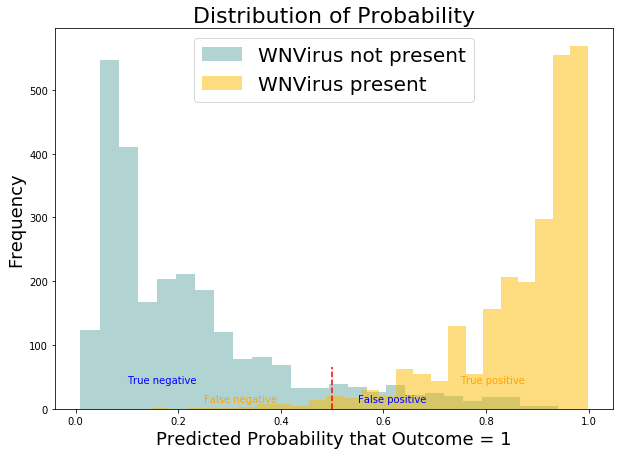

In [332]:
# Evaluation VotingClassifier
div_prob(vc,X_test_scaled)

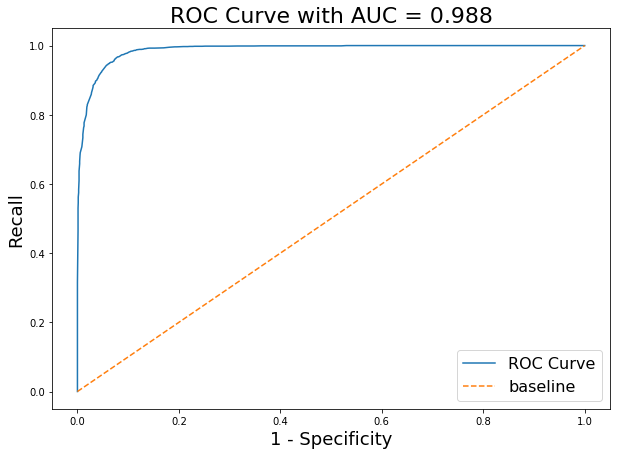

In [337]:
roc_curve(vc,X_test_scaled)

In [338]:
X_test_subm_scaled = ss.transform(X_test_submit)
submit_df = pd.DataFrame()
submit_df['id'] = main_df_test['id']
submit_df['wnvpresent'] = vc.predict(X_test_subm_scaled)
submit_df.to_csv('../datasets/submission.csv', index=False)

### Kaggle submition scores

|Private Score|Public Score|
|--|--|
|0.61716|0.63410|

From the scores, we can conclude that our model generalizability is not so well.


In [359]:
looking for false negative predictions
pred_proba = vc.predict_proba(X_test_scaled)
pred = vc.predict(X_test_scaled)
pred_df = pd.DataFrame({'true_values': y_test,
                        'predict':pred,
                        'pred_probs':list(pred_proba)})

wrong_predictions=pred_df[(pred_df['true_values']-pred_df['predict'])==1]
wrong_predictions
# X_test.loc[wrong_predictions.index,:]

,true_values,predict,pred_probs
9015,1,0,"[0.5118266410451519, 0.4881733589548481]"
18279,1,0,"[0.5118266410451519, 0.4881733589548481]"
15959,1,0,"[0.5051059965870229, 0.4948940034129771]"
14895,1,0,"[0.5051059965870229, 0.4948940034129771]"
17117,1,0,"[0.544917374464152, 0.45508262553584794]"
7399,1,0,"[0.5918419444791706, 0.40815805552082934]"
8854,1,0,"[0.5567206914202392, 0.4432793085797609]"
8998,1,0,"[0.5661400648589984, 0.4338599351410017]"
17984,1,0,"[0.5844075257136284, 0.4155924742863715]"
10346,1,0,"[0.5370517132507983, 0.46294828674920163]"


Most of false negative probabilities are close to threshold of 0.5.
Let's use threshold of 0.6